# Deep Learning-Driven Diagnosis of Breast Cancer: An Optimized and Comparative Approach Using the Wisconsin Dataset

**Authors:** Mohan Rajesh Dasari, Sandeep Kumar Vupputuri, Raghava Sammeta, Akash Sunkavilli  
**Institution:** Kennesaw State University  
**Department:** Computer Science

## Abstract

This notebook implements a comprehensive deep learning-based diagnostic framework for breast cancer classification using the Wisconsin Diagnostic Breast Cancer (WDBC) dataset. The project incorporates modern deep neural network enhancements including dropout, batch normalization, and systematic hyperparameter tuning. We provide a thorough comparison with classical machine learning models (Support Vector Machine and Random Forest) and include interpretability analysis using SHAP.

## Table of Contents

1. [Data Loading and Preprocessing](#1-data-loading-and-preprocessing)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
3. [Baseline Models Implementation](#3-baseline-models-implementation)
4. [Deep Neural Network Development](#4-deep-neural-network-development)
5. [Hyperparameter Tuning](#5-hyperparameter-tuning)
6. [Model Evaluation and Comparison](#6-model-evaluation-and-comparison)
7. [Interpretability Analysis](#7-interpretability-analysis)
8. [Results and Conclusions](#8-results-and-conclusions)

## Library Imports and Setup

In [1]:
# Data manipulation and numerical computing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import ParameterGrid

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Interpretability - using sklearn feature importance instead of SHAP
from sklearn.inspection import permutation_importance

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Utility libraries
import time
from datetime import datetime
import os
import sklearn

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

# TensorFlow GPU configuration (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU available: {physical_devices[0]}")
else:
    print("GPU not available, using CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow version: 2.18.0
Scikit-learn version: 1.6.1


## 1. Data Loading and Preprocessing

The Wisconsin Diagnostic Breast Cancer (WDBC) dataset contains 569 instances with 30 real-valued features computed from digitized images of fine needle aspirate (FNA) samples. Each feature describes properties of cell nuclei such as radius, texture, perimeter, area, smoothness, compactness, concavity, and fractal dimension.

In [2]:
# Load the Wisconsin Breast Cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for easier manipulation
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"\nClass distribution:")
print(df['diagnosis'].value_counts())
print(f"\nClass percentages:")
print(df['diagnosis'].value_counts(normalize=True) * 100)

# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset Information:
Shape: (569, 32)
Features: 30
Classes: ['malignant' 'benign']

Class distribution:
diagnosis
benign       357
malignant    212
Name: count, dtype: int64

Class percentages:
diagnosis
benign       62.741652
malignant    37.258348
Name: proportion, dtype: float64

First 5 rows of the dataset:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant


In [3]:
# Check for missing values and basic statistics
print("Missing values per column:")
print(df.isnull().sum().sum())

print("\nBasic statistics:")
df.describe()

Missing values per column:
0

Basic statistics:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [4]:
# Feature categorization for better understanding
# Features are computed for each cell nucleus with mean, standard error, and worst values
feature_groups = {
    'mean': [col for col in data.feature_names if 'mean' in col or col in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal_dimension']],
    'se': [col for col in data.feature_names if 'se' in col],
    'worst': [col for col in data.feature_names if 'worst' in col]
}

# Since the dataset has 30 features, let's group them properly
mean_features = data.feature_names[:10]
se_features = data.feature_names[10:20]
worst_features = data.feature_names[20:30]

print("Feature Groups:")
print(f"Mean features (10): {list(mean_features)}")
print(f"\nStandard Error features (10): {list(se_features)}")
print(f"\nWorst features (10): {list(worst_features)}")

Feature Groups:
Mean features (10): [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]

Standard Error features (10): [np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('smoothness error'), np.str_('compactness error'), np.str_('concavity error'), np.str_('concave points error'), np.str_('symmetry error'), np.str_('fractal dimension error')]

Worst features (10): [np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension')]


In [5]:
# Data preprocessing
# Split the data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data split sizes:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")

# Enhanced preprocessing specifically for DNNs
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline

# Create enhanced features for better DNN performance
polynomial_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = polynomial_features.fit_transform(X_train)
X_val_poly = polynomial_features.transform(X_val)
X_test_poly = polynomial_features.transform(X_test)

# Feature selection - select top 50 features for better DNN performance
feature_selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = feature_selector.fit_transform(X_train_poly, y_train)
X_val_selected = feature_selector.transform(X_val_poly)
X_test_selected = feature_selector.transform(X_test_poly)

# Use RobustScaler for better outlier resistance
robust_scaler = RobustScaler()
X_train_dnn = robust_scaler.fit_transform(X_train_selected)
X_val_dnn = robust_scaler.transform(X_val_selected)
X_test_dnn = robust_scaler.transform(X_test_selected)

print("Enhanced preprocessing for DNNs completed.")
print(f"Original features: {X_train.shape[1]}")
print(f"Enhanced features: {X_train_dnn.shape[1]}")
print(f"Training set mean: {X_train_scaled.mean():.6f}")
print(f"Training set std: {X_train_scaled.std():.6f}")

Data split sizes:
Training set: 341 samples
Validation set: 114 samples
Test set: 114 samples

Feature scaling completed.
Enhanced preprocessing for DNNs completed.
Original features: 30
Enhanced features: 50
Training set mean: -0.000000
Training set std: 1.000000


## 2. Exploratory Data Analysis

Let's explore the dataset to understand the relationships between features and the target variable.

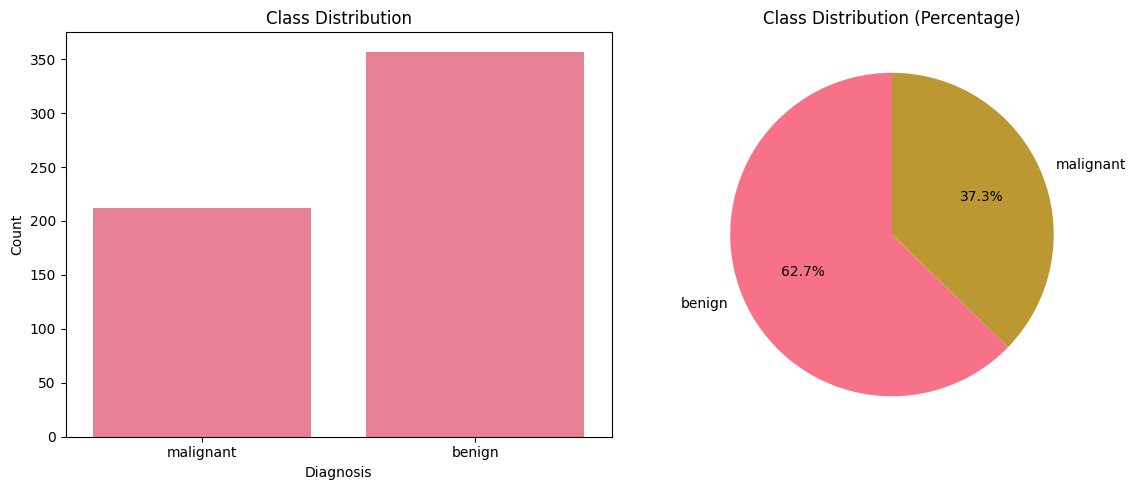

In [6]:
# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df, x='diagnosis', ax=axes[0])
axes[0].set_title('Class Distribution')
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Count')

# Pie chart
class_counts = df['diagnosis'].value_counts()
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

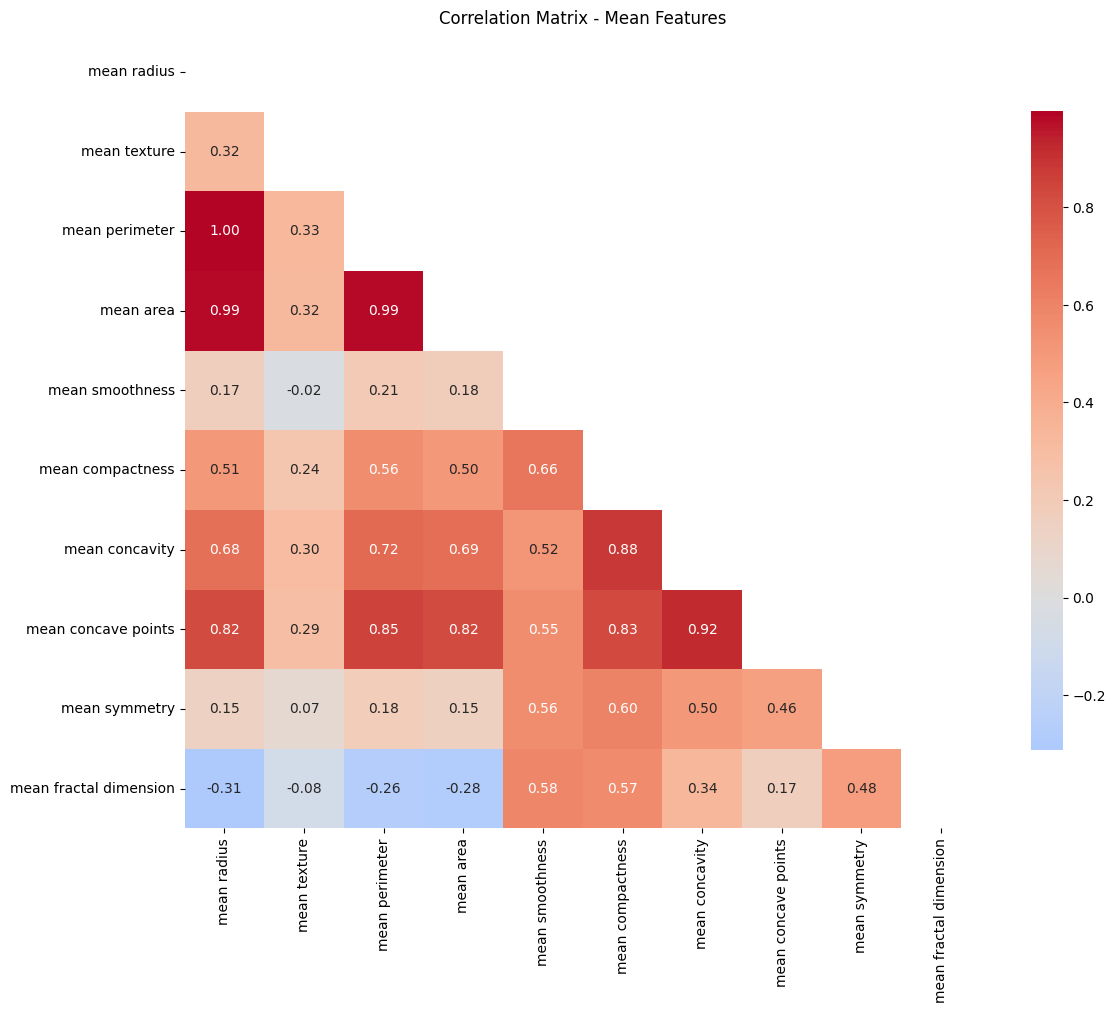

In [7]:
# Correlation matrix for mean features
plt.figure(figsize=(12, 10))
correlation_matrix = df[list(mean_features)].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Mean Features')
plt.tight_layout()
plt.show()

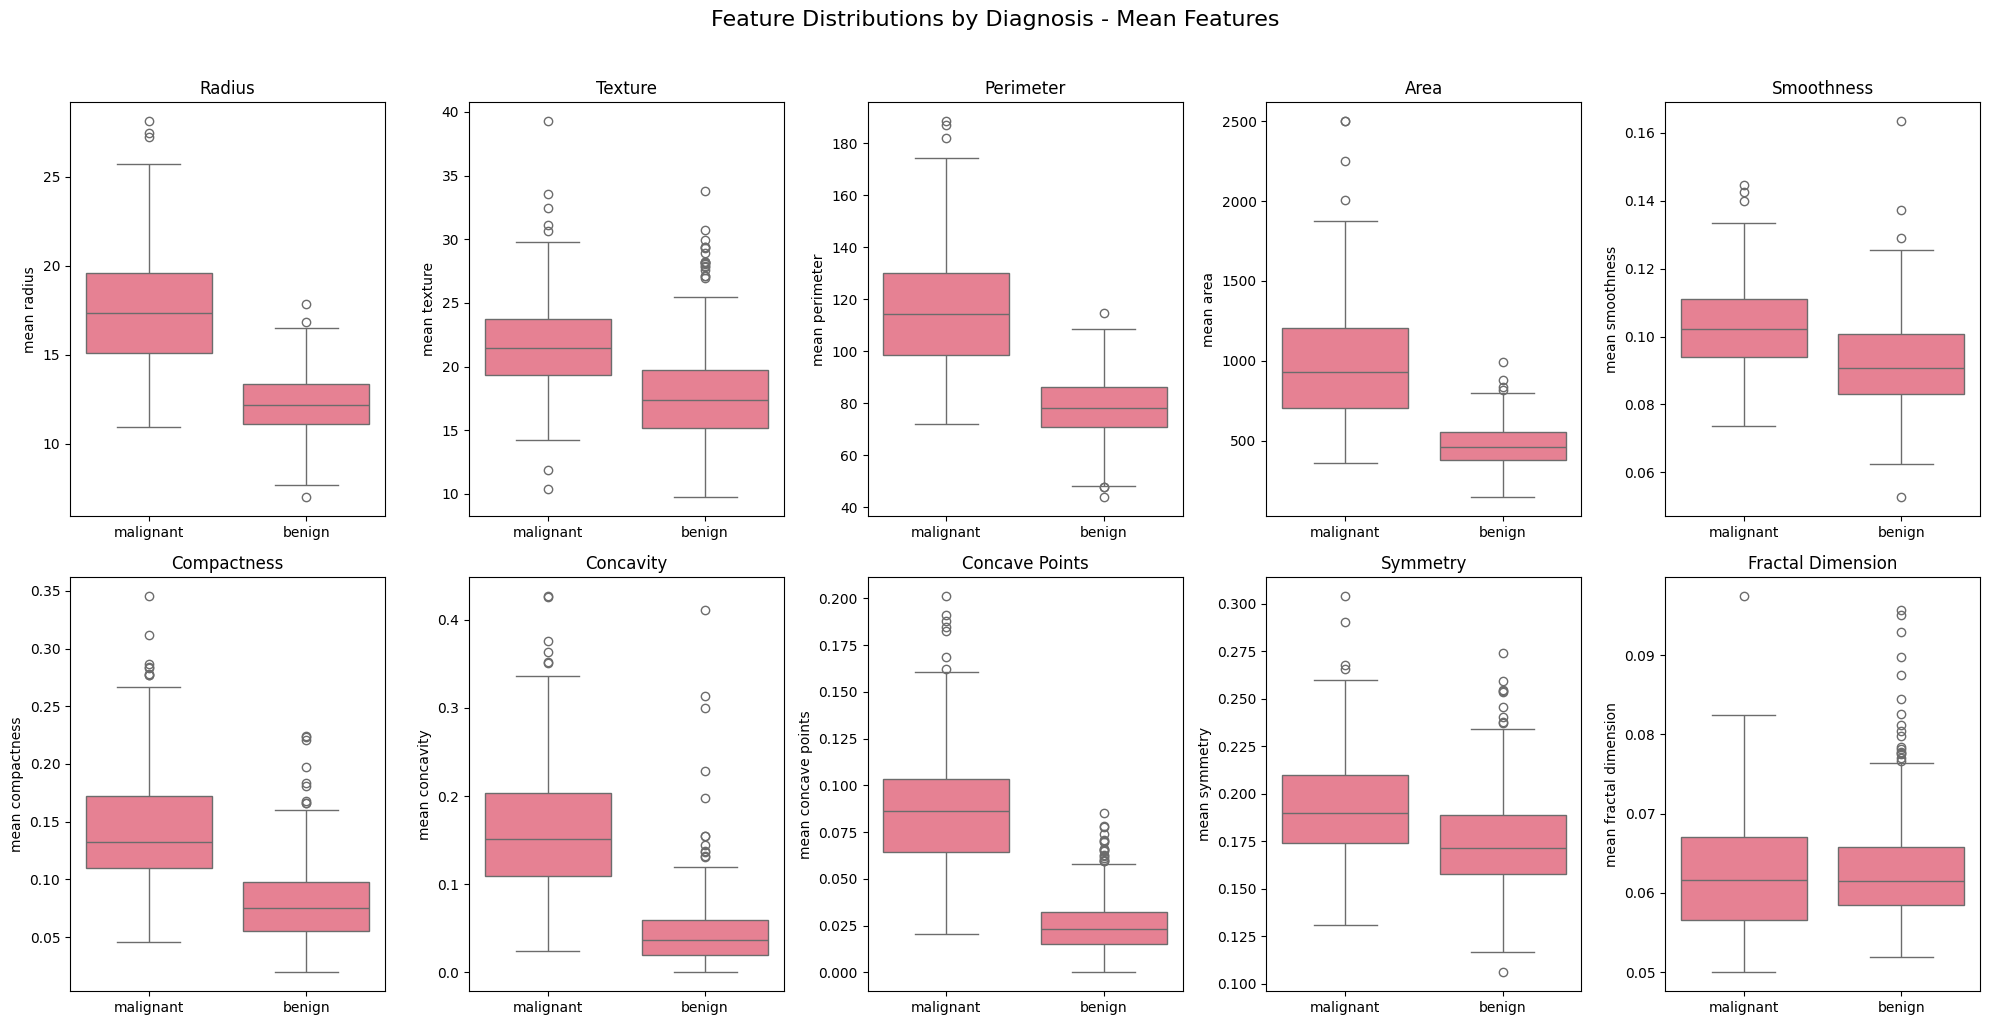

In [8]:
# Feature distributions by diagnosis
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(mean_features):
    sns.boxplot(data=df, x='diagnosis', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature.replace("mean ", "").title()}')
    axes[idx].set_xlabel('')

plt.suptitle('Feature Distributions by Diagnosis - Mean Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Statistical analysis of feature differences
def perform_statistical_tests(df, features):
    """
    Perform t-tests to check if there are significant differences
    in features between malignant and benign cases.
    """
    results = []

    malignant_data = df[df['diagnosis'] == 'malignant']
    benign_data = df[df['diagnosis'] == 'benign']

    for feature in features:
        malignant_values = malignant_data[feature]
        benign_values = benign_data[feature]

        # Perform independent t-test
        t_stat, p_value = stats.ttest_ind(malignant_values, benign_values)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(malignant_values) - 1) * malignant_values.var() +
                             (len(benign_values) - 1) * benign_values.var()) /
                            (len(malignant_values) + len(benign_values) - 2))
        cohens_d = (malignant_values.mean() - benign_values.mean()) / pooled_std

        results.append({
            'feature': feature,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05
        })

    return pd.DataFrame(results)

# Perform statistical tests for mean features
stats_results = perform_statistical_tests(df, mean_features)
stats_results = stats_results.sort_values('p_value')

print("Statistical significance of feature differences (sorted by p-value):")
print(stats_results.round(4))

Statistical significance of feature differences (sorted by p-value):
                  feature  t_statistic  p_value  cohens_d  significant
7     mean concave points      29.3543   0.0000    2.5452         True
2          mean perimeter      26.4052   0.0000    2.2895         True
0             mean radius      25.4358   0.0000    2.2055         True
3               mean area      23.9387   0.0000    2.0757         True
6          mean concavity      23.1040   0.0000    2.0033         True
5        mean compactness      17.6984   0.0000    1.5346         True
1            mean texture      10.8672   0.0000    0.9423         True
4         mean smoothness       9.1461   0.0000    0.7930         True
8           mean symmetry       8.3383   0.0000    0.7230         True
9  mean fractal dimension      -0.3057   0.7599   -0.0265        False


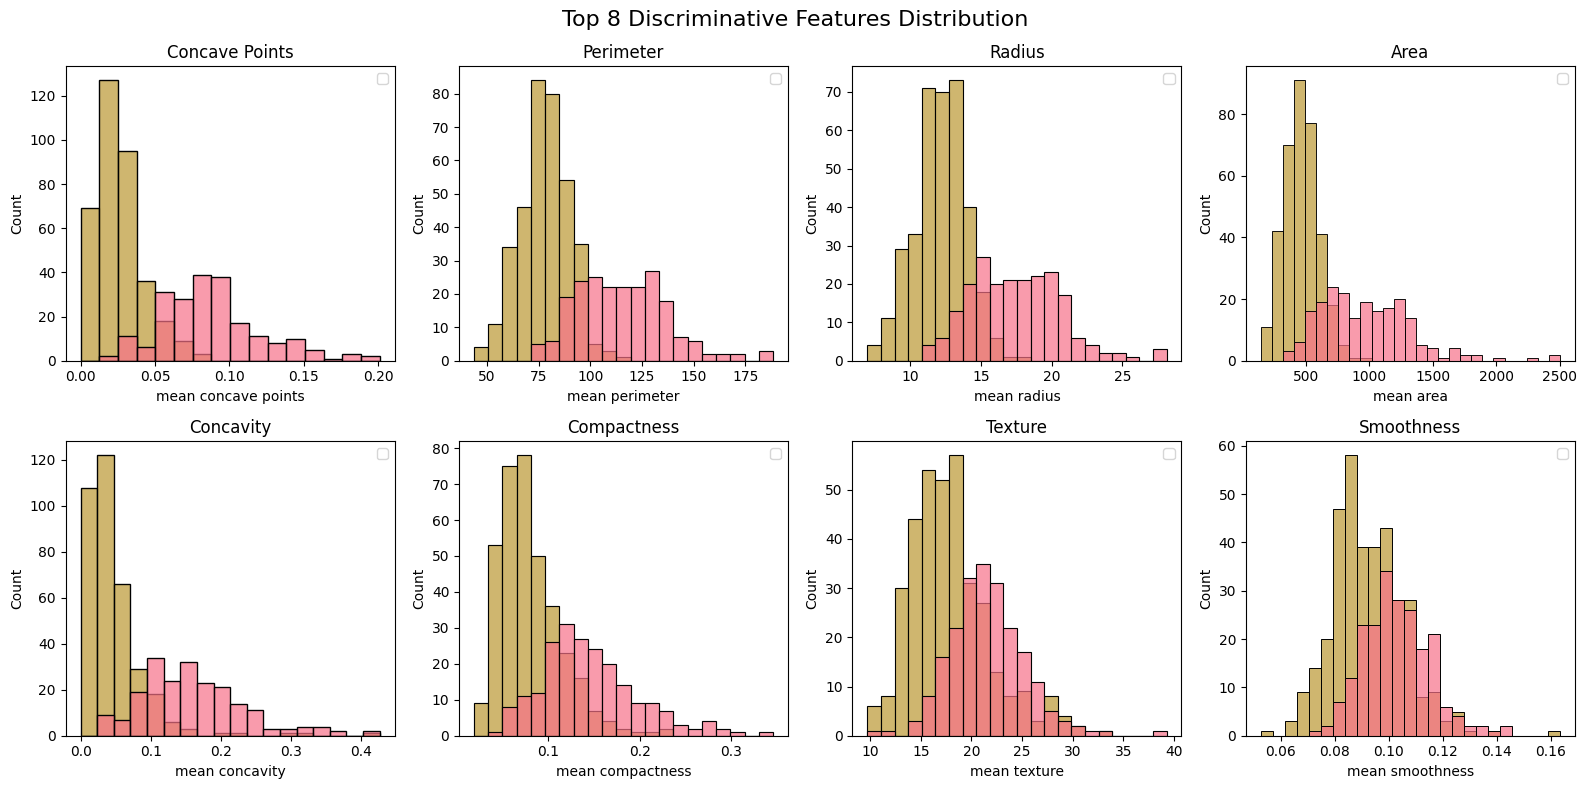

In [10]:
# Top discriminative features visualization
top_features = stats_results.head(8)['feature'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    sns.histplot(data=df, x=feature, hue='diagnosis', alpha=0.7, ax=axes[idx])
    axes[idx].set_title(f'{feature.replace("mean ", "").title()}')
    axes[idx].legend()

plt.suptitle('Top 8 Discriminative Features Distribution', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Baseline Models Implementation

We'll implement Support Vector Machine (SVM) and Random Forest classifiers as baseline models for comparison with our deep learning approach.

In [11]:
# Utility functions for model evaluation
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation function.
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # Create results dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    return results, y_pred, y_pred_proba

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name, ax=None):
    """
    Plot ROC curve.
    """
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)

        if ax is None:
            plt.figure(figsize=(6, 5))
            ax = plt.gca()

        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)

        return fpr, tpr, roc_auc
    return None, None, None

In [14]:
# Support Vector Machine (SVM) Implementation
print("Training Support Vector Machine...")

# SVM with hyperparameter tuning using GridSearchCV
svm_param_grid = {
    'C': [0.1, 1.0],
    'gamma': ['scale'],
    'kernel': ['linear', 'rbf']
}

svm_base = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm_base, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

start_time = time.time()
svm_grid.fit(X_train_scaled, y_train)
svm_training_time = time.time() - start_time

print(f"SVM training completed in {svm_training_time:.2f} seconds")
print(f"Best SVM parameters: {svm_grid.best_params_}")
print(f"Best cross-validation score: {svm_grid.best_score_:.4f}")

# Evaluate SVM
svm_results, svm_pred, svm_pred_proba = evaluate_model(svm_grid.best_estimator_, X_test_scaled, y_test, 'SVM')
print("\nSVM Test Results:")
for key, value in svm_results.items():
    if key != 'Model' and value is not None:
        print(f"{key}: {value:.4f}")

Training Support Vector Machine...
SVM training completed in 5.28 seconds
Best SVM parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9794

SVM Test Results:
Accuracy: 0.9825
Precision: 0.9861
Recall: 0.9861
F1-Score: 0.9861
ROC-AUC: 0.9950


In [16]:
# Random Forest Implementation
print("Training Random Forest...")

# Random Forest with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100], # Reduced to prevent overfitting,
    'max_depth': [5, 10],  # Shallow trees to prevent overfitting,
    'min_samples_split': [5, 10],  # Higher values to prevent overfitting,
    'min_samples_leaf': [2, 4],  # Higher values to prevent overfitting,
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42)
rf_grid = RandomizedSearchCV(rf_base, rf_param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)  # Reduced iterations to prevent overfitting

start_time = time.time()
rf_grid.fit(X_train_scaled, y_train)
rf_training_time = time.time() - start_time

print(f"Random Forest training completed in {rf_training_time:.2f} seconds")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Evaluate Random Forest
rf_results, rf_pred, rf_pred_proba = evaluate_model(rf_grid.best_estimator_, X_test_scaled, y_test, 'Random Forest')
print("\nRandom Forest Test Results:")
for key, value in rf_results.items():
    if key != 'Model' and value is not None:
        print(f"{key}: {value:.4f}")

Training Random Forest...
Random Forest training completed in 10.82 seconds
Best Random Forest parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}
Best cross-validation score: 0.9560

Random Forest Test Results:
Accuracy: 0.9474
Precision: 0.9583
Recall: 0.9583
F1-Score: 0.9583
ROC-AUC: 0.9904


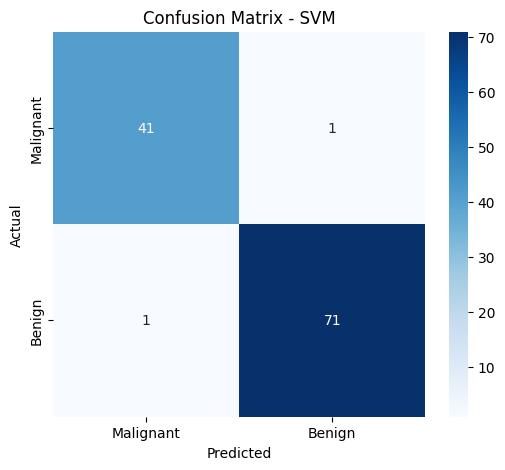

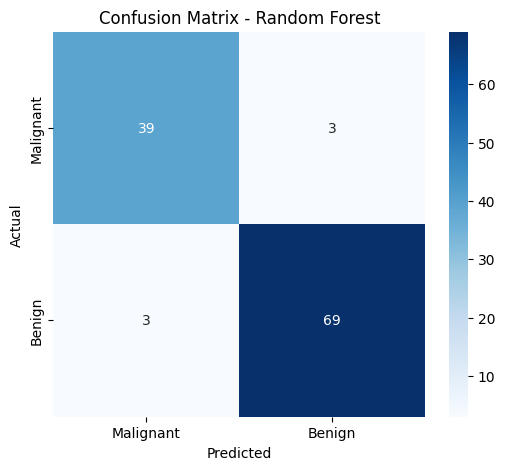

<Figure size 800x600 with 0 Axes>

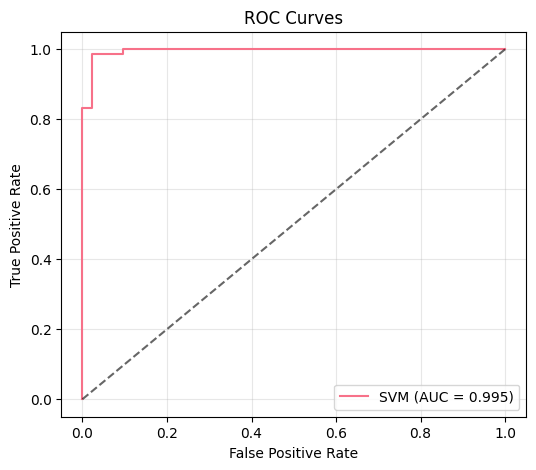

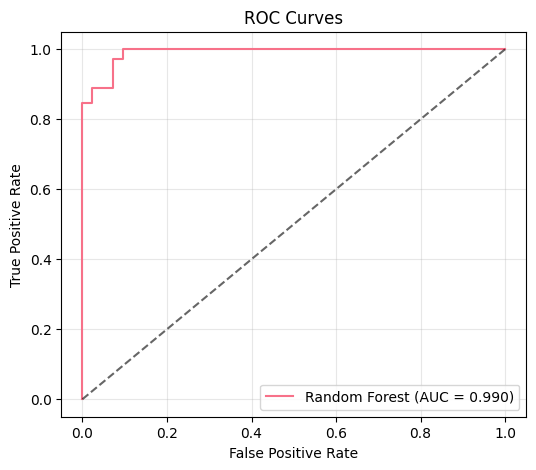

In [18]:
# Confusion matrices
plot_confusion_matrix(y_test, svm_pred, 'SVM')
plot_confusion_matrix(y_test, rf_pred, 'Random Forest')

# ROC curves comparison
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, svm_pred_proba, 'SVM')
plot_roc_curve(y_test, rf_pred_proba, 'Random Forest')
plt.show()

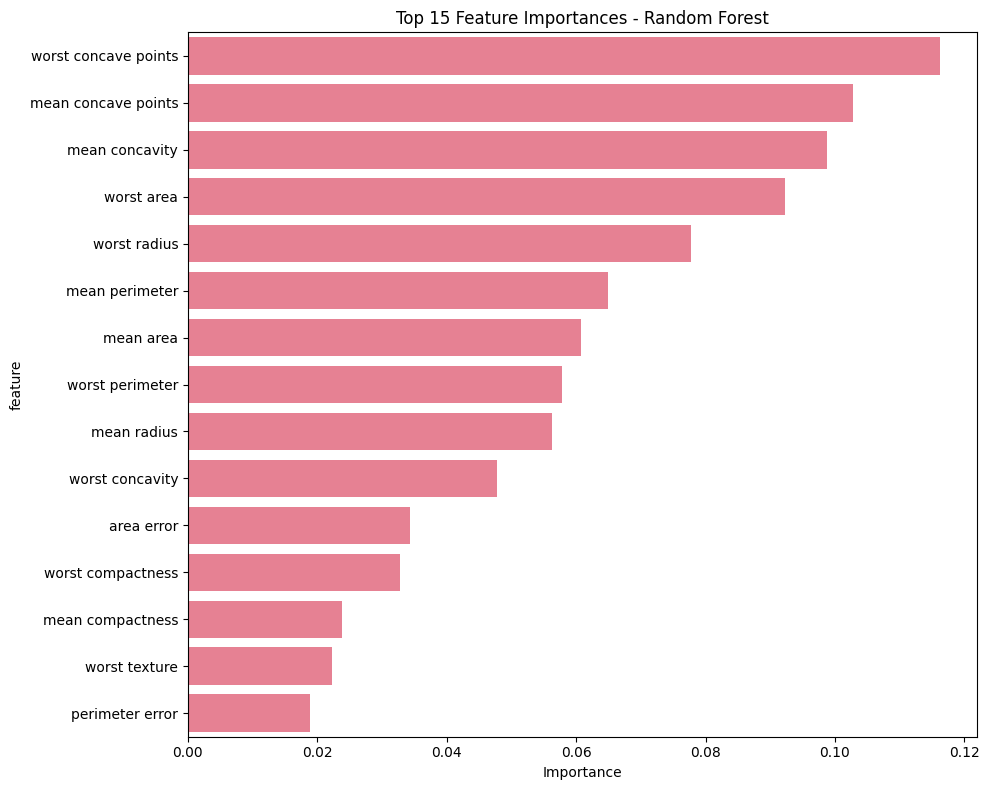

Top 10 most important features:
                 feature  importance
27  worst concave points    0.116156
7    mean concave points    0.102767
6         mean concavity    0.098746
23            worst area    0.092351
20          worst radius    0.077743
2         mean perimeter    0.064956
3              mean area    0.060813
22       worst perimeter    0.057859
0            mean radius    0.056201
26       worst concavity    0.047813


In [19]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': data.feature_names,
    'importance': rf_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

## 4. Deep Neural Network Development

Now we'll implement a deep neural network with modern enhancements including dropout, batch normalization, and proper regularization techniques.

In [20]:
# Deep Neural Network Architecture
def create_dnn_model(input_dim, hidden_layers=[512, 256, 128, 64], dropout_rate=0.3, l2_reg=0.001):
    """
    Create a deep neural network with dropout, batch normalization, and L2 regularization.

    Args:
        input_dim: Number of input features
        hidden_layers: List of hidden layer sizes
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization strength

    Returns:
        Compiled Keras model
    """
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Hidden layers with batch normalization and dropout
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg),
            name=f'hidden_{i+1}'
        ))
        model.add(layers.BatchNormalization(name=f'batch_norm_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid', name='output'))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Create initial model
dnn_model = create_dnn_model(X_train_dnn.shape[1])

# Display model architecture
print("Deep Neural Network Architecture:")
dnn_model.summary()

# Visualize model architecture
try:
    plot_model(dnn_model, to_file='dnn_architecture.png', show_shapes=True, show_layer_names=True)
    print("\nModel architecture saved as 'dnn_architecture.png'")
except:
    print("\nCould not save model architecture diagram (graphviz not available)")

Deep Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 512)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,497 (791.00 KB)

 Trainable params: 200,577 (783.50 KB)

 Non-trainable params: 1,920 (7.50 KB)


Model architecture saved as 'dnn_architecture.png'


In [22]:
# Training callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_dnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the initial model
print("Training Deep Neural Network...")
start_time = time.time()

history = dnn_model.fit(
    X_train_dnn, y_train,
    validation_data=(X_val_dnn, y_val),
    epochs=300,  # Increased for better convergence,
    batch_size=16,  # Smaller batch for better gradient updates,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)

dnn_training_time = time.time() - start_time
print(f"\nDNN training completed in {dnn_training_time:.2f} seconds")

Training Deep Neural Network...
Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7661 - loss: 1.1698 - precision: 0.8438 - recall: 0.7758
Epoch 1: val_loss improved from inf to 1.02515, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.7703 - loss: 1.1626 - precision: 0.8469 - recall: 0.7795 - val_accuracy: 0.9649 - val_loss: 1.0251 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 2/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9349 - loss: 0.8515 - precision: 0.9684 - recall: 0.9287  
Epoch 2: val_loss improved from 1.02515 to 0.94373, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9386 - loss: 0.8514 - precision: 0.9660 - recall: 0.9367 - val_accuracy: 0.9386 - val_loss: 0.9437 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9592 - loss: 0.8101 - precision: 0.9593 - recall: 0.9760 
Epoch 3: val_loss improved from 0.94373 to 0.91577, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9589 - loss: 0.8121 - precision: 0.9590 - recall: 0.9759 - val_accuracy: 0.9298 - val_loss: 0.9158 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/300
14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9628 - loss: 0.8151 - precision: 0.9590 - recall: 0.9827 
Epoch 4: val_loss improved from 0.91577 to 0.90834, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9599 - loss: 0.8235 - precision: 0.9547 - recall: 0.9825 - val_accuracy: 0.9211 - val_loss: 0.9083 - val_precision: 0.8875 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9701 - loss: 0.7851 - precision: 0.9714 - recall: 0.9813 
Epoch 5: val_loss improved from 0.90834 to 0.90265, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9670 - loss: 0.7891 - precision: 0.9669 - recall: 0.9809 - val_accuracy: 0.9035 - val_loss: 0.9026 - val_precision: 0.8659 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9565 - loss: 0.7798 - precision: 0.9732 - recall: 0.9582 
Epoch 6: val_loss improved from 0.90265 to 0.86547, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9564 - loss: 0.7811 - precision: 0.9705 - recall: 0.9607 - val_accuracy: 0.9298 - val_loss: 0.8655 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9600 - loss: 0.7896 - precision: 0.9627 - recall: 0.9736 
Epoch 7: val_loss improved from 0.86547 to 0.85417, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9592 - loss: 0.7926 - precision: 0.9626 - recall: 0.9723 - val_accuracy: 0.9298 - val_loss: 0.8542 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9627 - loss: 0.7763 - precision: 0.9715 - recall: 0.9699 
Epoch 8: val_loss improved from 0.85417 to 0.81951, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9635 - loss: 0.7752 - precision: 0.9707 - recall: 0.9718 - val_accuracy: 0.9298 - val_loss: 0.8195 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9707 - loss: 0.7404 - precision: 0.9786 - recall: 0.9758 
Epoch 9: val_loss improved from 0.81951 to 0.81758, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9716 - loss: 0.7409 - precision: 0.9772 - recall: 0.9783 - val_accuracy: 0.9298 - val_loss: 0.8176 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/300
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 0.7281 - precision: 0.9502 - recall: 0.9709 
Epoch 10: val_loss improved from 0.81758 to 0.77503, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9497 - loss: 0.7296 - precision: 0.9501 - recall: 0.9704 - val_accuracy: 0.9386 - val_loss: 0.7750 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9512 - loss: 0.7320 - precision: 0.9586 - recall: 0.9648 
Epoch 11: val_loss did not improve from 0.77503
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9510 - loss: 0.7344 - precision: 0.9569 - recall: 0.9662 - val_accuracy: 0.9386 - val_loss: 0.7794 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.7037 - precision: 0.9700 - recall: 0.9930 
Epoch 12: val_loss improved from 0.77503 to 0.76095, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9749 - loss: 0.7072 - precision: 0.9684 - recall: 0.9922 - val_accuracy: 0.9386 - val_loss: 0.7610 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 13/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.7011 - precision: 0.9763 - recall: 0.9554 
Epoch 13: val_loss did not improve from 0.76095
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9561 - loss: 0.7048 - precision: 0.9727 - recall: 0.9567 - val_accuracy: 0.9298 - val_loss: 0.7653 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 14/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.6858 - precision: 0.9647 - recall: 0.9949  
Epoch 14: val_loss improved from 0.76095 to 0.72993, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9739 - loss: 0.6862 - precision: 0.9644 - recall: 0.9950 - val_accuracy: 0.9474 - val_loss: 0.7299 - val_precision: 0.9221 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9721 - loss: 0.6909 - precision: 0.9767 - recall: 0.9785 
Epoch 15: val_loss improved from 0.72993 to 0.72551, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9707 - loss: 0.6901 - precision: 0.9743 - recall: 0.9789 - val_accuracy: 0.9386 - val_loss: 0.7255 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 16/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.6558 - precision: 0.9698 - recall: 0.9926 
Epoch 16: val_loss improved from 0.72551 to 0.70559, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9748 - loss: 0.6569 - precision: 0.9693 - recall: 0.9910 - val_accuracy: 0.9386 - val_loss: 0.7056 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 17/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9790 - loss: 0.6398 - precision: 0.9823 - recall: 0.9841 
Epoch 17: val_loss did not improve from 0.70559
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9785 - loss: 0.6407 - precision: 0.9805 - recall: 0.9852 - val_accuracy: 0.9298 - val_loss: 0.7102 - val_precision: 0.8987 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 18/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9819 - loss: 0.6247 - precision: 0.9825 - recall: 0.9885  
Epoch 18: val_loss did not improve from 0.70559
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9814 - loss: 0.6272 - precision: 0.9815 - recall: 0.9888 - val_accuracy: 0.9386 - val_loss: 0.7133 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9917 - loss: 0.6057 - precision: 0.9868 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.6778 - val_precision: 0.9221 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 20/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.6150 - precision: 0.9701 - recall: 1.0000 
Epoch 20: val_loss improved from 0.67783 to 0.67122, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9804 - loss: 0.6163 - precision: 0.9696 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.6712 - val_precision: 0.9103 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 21/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.5934 - precision: 0.9824 - recall: 0.9949 
Epoch 21: val_loss improved from 0.67122 to 0.64966, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9846 - loss: 0.5956 - precision: 0.9806 - recall: 0.9950 - val_accuracy: 0.9561 - val_loss: 0.6497 - val_precision: 0.9342 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 22/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9805 - loss: 0.5880 - precision: 0.9823 - recall: 0.9865 
Epoch 22: val_loss improved from 0.64966 to 0.63430, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9797 - loss: 0.5900 - precision: 0.9805 - recall: 0.9872 - val_accuracy: 0.9474 - val_loss: 0.6343 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 23/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9906 - loss: 0.5724 - precision: 0.9907 - recall: 0.9942 
Epoch 23: val_loss did not improve from 0.63430
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9887 - loss: 0.5746 - precision: 0.9882 - recall: 0.9938 - val_accuracy: 0.9474 - val_loss: 0.6382 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 24/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.5727 - precision: 0.9831 - recall: 0.9927 
Epoch 24: val_loss did not improve from 0.63430
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.5767 - precision: 0.9815 - recall: 0.9907 - val_accuracy: 0.9298 - val_loss: 0.6950 - val_precision: 0.9091 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9585 - loss: 0.6163 - precision: 0.9651 - recall: 0.9696 - val_accuracy: 0.9474 - val_loss: 0.6262 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 26/300
11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9849 - loss: 0.5429 - precision: 0.9864 - recall: 0.9898  
Epoch 26: val_loss improved from 0.62618 to 0.61657, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9779 - loss: 0.5575 - precision: 0.9762 - recall: 0.9888 - val_accuracy: 0.9474 - val_loss: 0.6166 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 27/300
13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9863 - loss: 0.5381 - precision: 0.9892 - recall: 0.9889  
Epoch 27: val_loss improved from 0.61657 to 0.60271, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9843 - loss: 0.5363 - precision: 0.9866 - recall: 0.9882 - val_accuracy: 0.9386 - val_loss: 0.6027 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 28/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.5328 - precision: 0.9829 - recall: 0.9942  
Epoch 28: val_loss improved from 0.60271 to 0.58340, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9849 - loss: 0.5336 - precision: 0.9816 - recall: 0.9944 - val_accuracy: 0.9474 - val_loss: 0.5834 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 29/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.5316 - precision: 0.9784 - recall: 0.9780 
Epoch 29: val_loss did not improve from 0.58340
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9725 - loss: 0.5339 - precision: 0.9770 - recall: 0.9790 - val_accuracy: 0.9298 - val_loss: 0.6125 - val_precision: 0.9091 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 30/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9766 - loss: 0.5184 - precision: 0.9698 - recall: 0.9934 
Epoch 30: val_loss improved from 0.58340 to 0.58285, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9759 - loss: 0.5196 - precision: 0.9694 - recall: 0.9928 - val_accuracy: 0.9474 - val_loss: 0.5829 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 31/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.4905 - precision: 0.9874 - recall: 1.0000 
Epoch 31: val_loss improved from 0.58285 to 0.56248, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9910 - loss: 0.4923 - precision: 0.9858 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.5625 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 32/300
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9899 - loss: 0.4868 - precision: 0.9904 - recall: 0.9934 
Epoch 32: val_loss did not improve from 0.56248
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.4877 - precision: 0.9892 - recall: 0.9937 - val_accuracy: 0.9474 - val_loss: 0.5629 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 33/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.4874 - precision: 0.9912 - recall: 0.9892 
Epoch 33: val_loss did not improve from 0.56248
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9866 - loss: 0.4890 - precision: 0.9892 - recall: 0.9894 - val_accuracy: 0.9123 - val_loss: 0.6498 - val_precision: 0.8861 - val_recall: 0.9859 - learning_rate:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9759 - loss: 0.4829 - precision: 0.9694 - recall: 0.9928 - val_accuracy: 0.9561 - val_loss: 0.5584 - val_precision: 0.9583 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 35/300
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.4674 - precision: 0.9837 - recall: 1.0000 
Epoch 35: val_loss did not improve from 0.55844
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9884 - loss: 0.4710 - precision: 0.9817 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.5840 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 36/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9774 - loss: 0.4619 - precision: 0.9779 - recall: 0.9859 
Epoch 36: val_loss improved from 0.55844 to 0.53078, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9768 - loss: 0.4631 - precision: 0.9776 - recall: 0.9852 - val_accuracy: 0.9561 - val_loss: 0.5308 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 37/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - loss: 0.4798 - precision: 0.9742 - recall: 0.9834 
Epoch 37: val_loss did not improve from 0.53078
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9729 - loss: 0.4788 - precision: 0.9730 - recall: 0.9840 - val_accuracy: 0.9386 - val_loss: 0.5439 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 38/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.4571 - precision: 0.9746 - recall: 0.9991  
Epoch 38: val_loss did not improve from 0.53078
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9824 - loss: 0.4588 - precision: 0.9741 - recall: 0.9984 - val_accuracy: 0.9474 - val_loss: 0.5460 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9758 - loss: 0.4606 - precision: 0.9695 - recall: 0.9923 - val_accuracy: 0.9737 - val_loss: 0.5243 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 40/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.4551 - precision: 0.9825 - recall: 0.9834 
Epoch 40: val_loss improved from 0.52433 to 0.51559, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9784 - loss: 0.4546 - precision: 0.9815 - recall: 0.9840 - val_accuracy: 0.9474 - val_loss: 0.5156 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 41/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.4449 - precision: 0.9803 - recall: 0.9991 
Epoch 41: val_loss improved from 0.51559 to 0.50403, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9850 - loss: 0.4469 - precision: 0.9781 - recall: 0.9984 - val_accuracy: 0.9474 - val_loss: 0.5040 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 42/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - loss: 0.4349 - precision: 0.9781 - recall: 0.9876 
Epoch 42: val_loss did not improve from 0.50403
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9775 - loss: 0.4361 - precision: 0.9762 - recall: 0.9881 - val_accuracy: 0.9474 - val_loss: 0.5075 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 43/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.4249 - precision: 0.9870 - recall: 0.9982 
Epoch 43: val_loss did not improve from 0.50403
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - loss: 0.4286 - precision: 0.9859 - recall: 0.9963 - val_accuracy: 0.9474 - val_loss: 0.5118 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9804 - loss: 0.4173 - precision: 0.9777 - recall: 0.9912 - val_accuracy: 0.9474 - val_loss: 0.4958 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 45/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.4069 - precision: 0.9845 - recall: 0.9834 
Epoch 45: val_loss did not improve from 0.49584
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.4069 - precision: 0.9839 - recall: 0.9846 - val_accuracy: 0.9386 - val_loss: 0.5030 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 46/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.4060 - precision: 0.9778 - recall: 0.9851 
Epoch 46: val_loss improved from 0.49584 to 0.49287, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9757 - loss: 0.4084 - precision: 0.9776 - recall: 0.9835 - val_accuracy: 0.9474 - val_loss: 0.4929 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 47/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9780 - loss: 0.3953 - precision: 0.9662 - recall: 1.0000 
Epoch 47: val_loss improved from 0.49287 to 0.48732, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9782 - loss: 0.3958 - precision: 0.9663 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.4873 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 48/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.3772 - precision: 0.9956 - recall: 0.9884 
Epoch 48: val_loss did not improve from 0.48732
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9897 - loss: 0.3773 - precision: 0.9946 - recall: 0.9888 - val_accuracy: 0.9386 - val_loss: 0.5234 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 49/300
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9836 - loss: 0.3855 - precision: 0.9744 - recall: 1.0000 
Epoch 49: val_loss improved from 0.48732 to 0.48307, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9833 - loss: 0.3858 - precision: 0.9746 - recall: 0.9994 - val_accuracy: 0.9386 - val_loss: 0.4831 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 50/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.3821 - precision: 0.9750 - recall: 0.9942 
Epoch 50: val_loss improved from 0.48307 to 0.46904, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9792 - loss: 0.3835 - precision: 0.9736 - recall: 0.9938 - val_accuracy: 0.9474 - val_loss: 0.4690 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 51/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.3689 - precision: 0.9822 - recall: 0.9950 
Epoch 51: val_loss improved from 0.46904 to 0.46694, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9862 - loss: 0.3700 - precision: 0.9830 - recall: 0.9950 - val_accuracy: 0.9561 - val_loss: 0.4669 - val_precision: 0.9583 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 52/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9780 - loss: 0.3772 - precision: 0.9822 - recall: 0.9825 
Epoch 52: val_loss did not improve from 0.46694
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9777 - loss: 0.3770 - precision: 0.9812 - recall: 0.9831 - val_accuracy: 0.9474 - val_loss: 0.4687 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 53/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9880 - loss: 0.3464 - precision: 0.9866 - recall: 0.9942  
Epoch 53: val_loss improved from 0.46694 to 0.43685, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9870 - loss: 0.3486 - precision: 0.9849 - recall: 0.9944 - val_accuracy: 0.9561 - val_loss: 0.4368 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 54/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9777 - loss: 0.3657 - precision: 0.9824 - recall: 0.9818 
Epoch 54: val_loss did not improve from 0.43685
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9774 - loss: 0.3658 - precision: 0.9813 - recall: 0.9825 - val_accuracy: 0.9561 - val_loss: 0.4410 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 55/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.3495 - precision: 0.9911 - recall: 0.9827 
Epoch 55: val_loss improved from 0.43685 to 0.41451, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9839 - loss: 0.3503 - precision: 0.9909 - recall: 0.9832 - val_accuracy: 0.9649 - val_loss: 0.4145 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 56/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.3354 - precision: 0.9828 - recall: 0.9991 
Epoch 56: val_loss did not improve from 0.41451
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9874 - loss: 0.3369 - precision: 0.9817 - recall: 0.9984 - val_accuracy: 0.9386 - val_loss: 0.4558 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 57/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.3369 - precision: 0.9873 - recall: 0.9942  
Epoch 57: val_loss did not improve from 0.41451
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9882 - loss: 0.3377 - precision: 0.9867 - recall: 0.9944 - val_accuracy: 0.9649 - val_loss: 0.4294 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9799 - loss: 0.3169 - precision: 0.9785 - recall: 0.9894 - val_accuracy: 0.9474 - val_loss: 0.4060 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 63/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.3094 - precision: 0.9828 - recall: 1.0000 
Epoch 63: val_loss improved from 0.40601 to 0.38612, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9889 - loss: 0.3098 - precision: 0.9825 - recall: 1.0000 - val_accuracy: 0.9649 - val_loss: 0.3861 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 64/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.3096 - precision: 0.9823 - recall: 0.9765 
Epoch 64: val_loss did not improve from 0.38612
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9741 - loss: 0.3100 - precision: 0.9805 - recall: 0.9789 - val_accuracy: 0.9474 - val_loss: 0.3969 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 65/300
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.3071 - precision: 0.9875 - recall: 0.9869  
Epoch 65: val_loss did not improve from 0.38612
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9837 - loss: 0.3097 - precision: 0.9867 - recall: 0.9872 - val_accuracy: 0.9386 - val_loss: 0.4217 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9905 - loss: 0.3036 - precision: 0.9850 - recall: 1.0000 - val_accuracy: 0.9561 - val_loss: 0.3833 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 68/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.2827 - precision: 0.9870 - recall: 0.9950 
Epoch 68: val_loss did not improve from 0.38328
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9886 - loss: 0.2826 - precision: 0.9867 - recall: 0.9950 - val_accuracy: 0.9649 - val_loss: 0.3926 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 69/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9856 - loss: 0.2832 - precision: 0.9829 - recall: 0.9942
Epoch 69: val_loss did not improve from 0.38328
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9854 - loss: 0.2825 - precision: 0.9824 - recall: 0.9944 - val_accuracy: 0.9474 - val_loss: 0.3952 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.2854 - precision: 0.9824 - recall: 0.9928 - val_accuracy: 0.9561 - val_loss: 0.3626 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 71/300
13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.2813 - precision: 0.9859 - recall: 0.9955 
Epoch 71: val_loss did not improve from 0.36257
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9851 - loss: 0.2900 - precision: 0.9814 - recall: 0.9950 - val_accuracy: 0.9649 - val_loss: 0.3704 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 72/300
14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9893 - loss: 0.2662 - precision: 0.9886 - recall: 0.9943 
Epoch 72: val_loss improved from 0.36257 to 0.33960, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9872 - loss: 0.2685 - precision: 0.9867 - recall: 0.9928 - val_accuracy: 0.9649 - val_loss: 0.3396 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 73/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9910 - loss: 0.2669 - precision: 0.9862 - recall: 0.9996
Epoch 73: val_loss did not improve from 0.33960
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9908 - loss: 0.2673 - precision: 0.9860 - recall: 0.9994 - val_accuracy: 0.9474 - val_loss: 0.3616 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 74/300
12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9906 - loss: 0.2627 - precision: 0.9904 - recall: 0.9946 
Epoch 74: val_loss did not improve from 0.33960
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9862 - loss: 0.2708 - precision: 0.9856 - recall: 0.9923 - val_accuracy: 0.9474 - val_loss: 0.3721 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9902 - loss: 0.2559 - precision: 0.9860 - recall: 0.9984 - val_accuracy: 0.9649 - val_loss: 0.3337 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 82/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9899 - loss: 0.2377 - precision: 0.9873 - recall: 0.9966 
Epoch 82: val_loss did not improve from 0.33372
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9885 - loss: 0.2395 - precision: 0.9867 - recall: 0.9949 - val_accuracy: 0.9474 - val_loss: 0.3597 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 83/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.2272 - precision: 0.9913 - recall: 1.0000 
Epoch 83: val_loss improved from 0.33372 to 0.33243, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9939 - loss: 0.2274 - precision: 0.9903 - recall: 1.0000 - val_accuracy: 0.9561 - val_loss: 0.3324 - val_precision: 0.9583 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 84/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9895 - loss: 0.2381 - precision: 0.9889 - recall: 0.9942 
Epoch 84: val_loss did not improve from 0.33243
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9887 - loss: 0.2387 - precision: 0.9875 - recall: 0.9944 - val_accuracy: 0.9386 - val_loss: 0.3438 - val_precision: 0.9211 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 85/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.2359 - precision: 0.9747 - recall: 0.9942  
Epoch 85: val_loss did not improve from 0.33243
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9798 - loss: 0.2360 - precision: 0.9740 - recall: 0.9944 - val_accuracy: 0.9474 - val_loss: 0.3445 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.2339 - precision: 0.9822 - recall: 0.9838 - val_accuracy: 0.9474 - val_loss: 0.3318 - val_precision: 0.9221 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 92/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.2078 - precision: 0.9872 - recall: 1.0000 
Epoch 92: val_loss improved from 0.33184 to 0.31361, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9917 - loss: 0.2079 - precision: 0.9868 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.3136 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 93/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.2015 - precision: 0.9978 - recall: 0.9950 
Epoch 93: val_loss improved from 0.31361 to 0.30624, saving model to best_dnn_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9945 - loss: 0.2033 - precision: 0.9962 - recall: 0.9950 - val_accuracy: 0.9649 - val_loss: 0.3062 - val_precision: 0.9589 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 94/300
15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.2151 - precision: 0.9919 - recall: 0.9918 
Epoch 94: val_loss did not improve from 0.30624
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9899 - loss: 0.2143 - precision: 0.9911 - recall: 0.9928 - val_accuracy: 0.9474 - val_loss: 0.3172 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 95/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9877 - loss: 0.2186 - precision: 0.9823 - recall: 0.9982  
Epoch 95: val_loss did not improve from 0.30624
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9872 - loss: 0.2189 - precision: 0.9822 - recall: 0.9976 - val_accuracy: 0.9474 - val_loss: 0.3379 - val_precision: 0.9221 - val_recall: 1.0000 - learning_rate

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9831 - loss: 0.2141 - precision: 0.9866 - recall: 0.9862 - val_accuracy: 0.9474 - val_loss: 0.3050 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 101/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.2159 - precision: 0.9869 - recall: 0.9892 
Epoch 101: val_loss did not improve from 0.30502
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9839 - loss: 0.2184 - precision: 0.9848 - recall: 0.9894 - val_accuracy: 0.9211 - val_loss: 0.4335 - val_precision: 0.8974 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 102/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.2278 - precision: 0.9781 - recall: 0.9946  
Epoch 102: val_loss did not improve from 0.30502
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9817 - loss: 0.2284 - precision: 0.9786 - recall: 0.9922 - val_accuracy: 0.9386 - val_loss: 0.3792 - val_precision: 0.9103 - val_recall: 1.0000 - learning_

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9972 - loss: 0.1712 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.2995 - val_precision: 0.9333 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 110/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.1698 - precision: 0.9913 - recall: 1.0000 
Epoch 110: val_loss did not improve from 0.29949
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.1696 - precision: 0.9911 - recall: 1.0000 - val_accuracy: 0.9561 - val_loss: 0.3085 - val_precision: 0.9459 - val_recall: 0.9859 - learning_rate: 0.0010
Epoch 111/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.2089 - precision: 0.9848 - recall: 0.9831 
Epoch 111: val_loss did not improve from 0.29949
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9804 - loss: 0.2087 - precision: 0.9839 - recall: 0.9846 - val_accuracy: 0.9474 - val_loss: 0.3089 - val_precision: 0.9333 - val_recall: 0.9859 - learning_r

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9838 - loss: 0.1829 - precision: 0.9829 - recall: 0.9912 - val_accuracy: 0.9474 - val_loss: 0.2834 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 113/300
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.1625 - precision: 0.9873 - recall: 0.9942 
Epoch 113: val_loss did not improve from 0.28341
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.1632 - precision: 0.9849 - recall: 0.9944 - val_accuracy: 0.9386 - val_loss: 0.3151 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 0.0010
Epoch 114/300
13/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9877 - loss: 0.1746 - precision: 0.9928 - recall: 0.9876  
Epoch 114: val_loss did not improve from 0.28341
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9870 - loss: 0.1788 - precision: 0.9910 - recall: 0.9881 - val_accuracy: 0.9474 - val_loss: 0.3143 - val_precision: 0.9452 - val_recall: 0.9718 - learning_

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9972 - loss: 0.1418 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.2817 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 133/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.1391 - precision: 0.9956 - recall: 1.0000 
Epoch 133: val_loss did not improve from 0.28174
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.1390 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.3088 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 134/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.1455 - precision: 0.9913 - recall: 0.9942 
Epoch 134: val_loss did not improve from 0.28174
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9909 - loss: 0.1455 - precision: 0.9911 - recall: 0.9944 - val_accuracy: 0.9474 - val_loss: 0.2936 - val_precision: 0.9452 - val_recall: 0.9718 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9944 - loss: 0.1415 - precision: 0.9911 - recall: 1.0000 - val_accuracy: 0.9649 - val_loss: 0.2773 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 137/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.1316 - precision: 1.0000 - recall: 0.9942 
Epoch 137: val_loss did not improve from 0.27734
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.1317 - precision: 1.0000 - recall: 0.9944 - val_accuracy: 0.9474 - val_loss: 0.2786 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 138/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.1291 - precision: 0.9956 - recall: 1.0000 
Epoch 138: val_loss did not improve from 0.27734
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.1291 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.2863 - val_precision: 0.9324 - val_recall: 0.9718 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.1285 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.2764 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 140/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.1253 - precision: 0.9956 - recall: 1.0000 
Epoch 140: val_loss did not improve from 0.27636
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.1260 - precision: 0.9947 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.3031 - val_precision: 0.9452 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 141/300
18/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.1312 - precision: 0.9956 - recall: 1.0000 
Epoch 141: val_loss did not improve from 0.27636
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.1306 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9474 - val_loss: 0.3065 - val_precision: 0.9452 - val_recall: 0.9718 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9943 - loss: 0.1189 - precision: 1.0000 - recall: 0.9908 - val_accuracy: 0.9386 - val_loss: 0.2543 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 149/300
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.1164 - precision: 0.9958 - recall: 1.0000 
Epoch 149: val_loss did not improve from 0.25425
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.1170 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.2789 - val_precision: 0.9324 - val_recall: 0.9718 - learning_rate: 5.0000e-04
Epoch 150/300
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.1148 - precision: 0.9956 - recall: 1.0000  
Epoch 150: val_loss did not improve from 0.25425
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.1147 - precision: 0.9955 - recall: 1.0000 - val_accuracy: 0.9386 - val_loss: 0.3073 - val_precision: 0.9324 - val_recall: 0.9718 - l

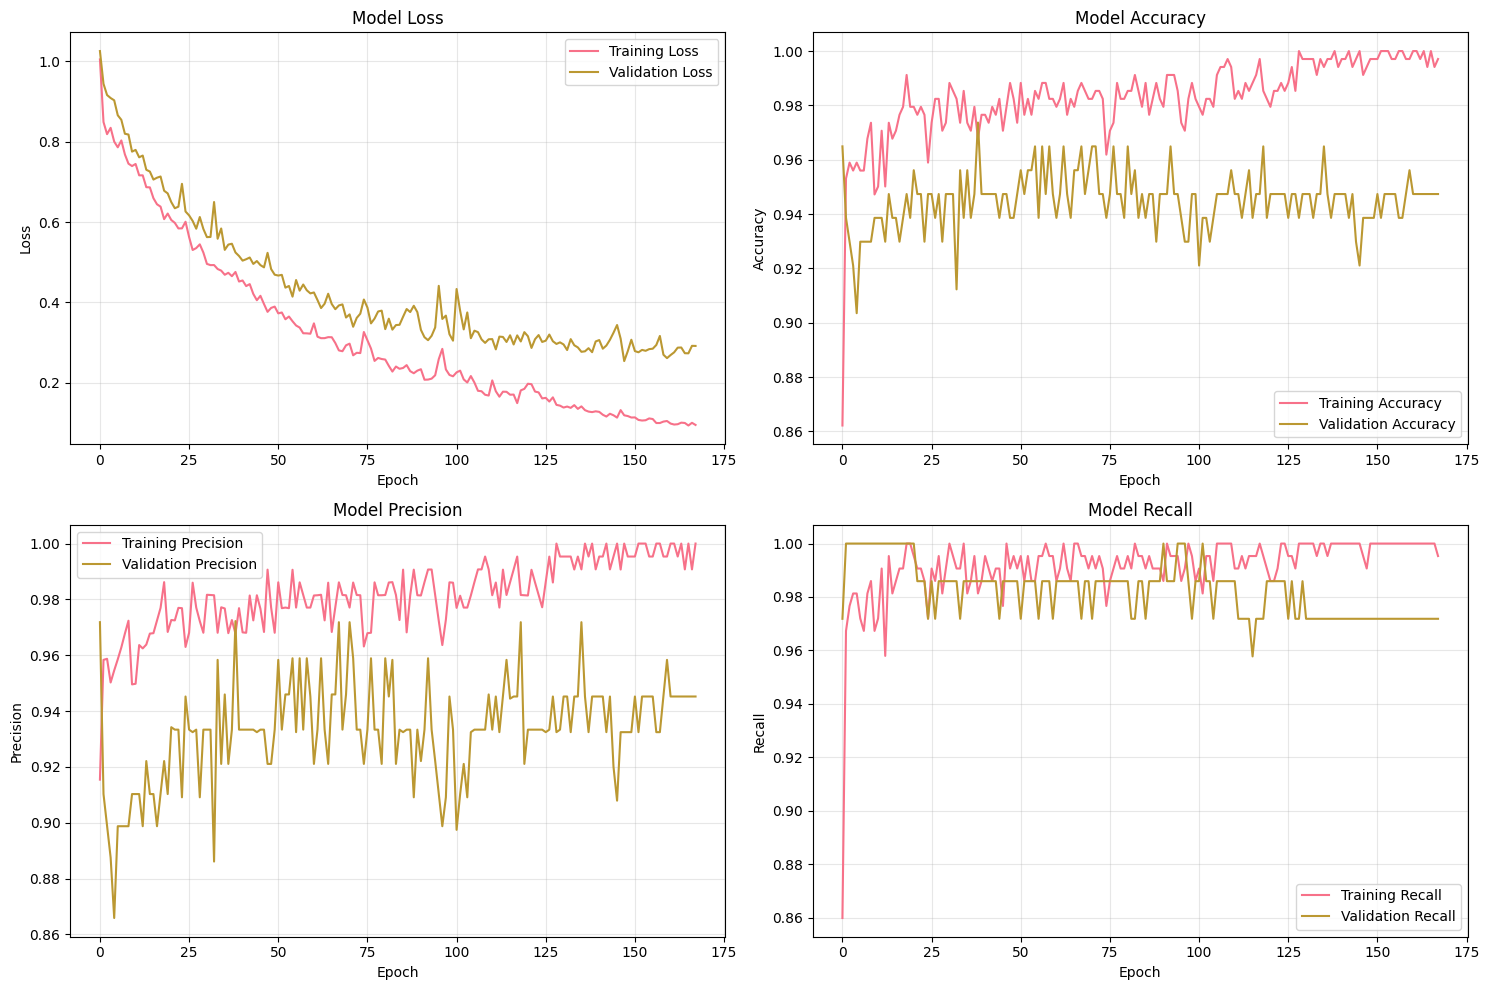

In [25]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics over epochs.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [26]:
# Evaluate initial DNN model
def evaluate_keras_model(model, X_test, y_test, model_name):
    """
    Evaluate Keras model and return metrics.
    """
    # Predictions
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    return results, y_pred, y_pred_proba

# Evaluate initial DNN
dnn_results, dnn_pred, dnn_pred_proba = evaluate_keras_model(dnn_model, X_test_dnn, y_test, 'DNN (Initial)')

print("Initial DNN Test Results:")
for key, value in dnn_results.items():
    if key != 'Model':
        print(f"{key}: {value:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Initial DNN Test Results:
Accuracy: 0.9561
Precision: 0.9718
Recall: 0.9583
F1-Score: 0.9650
ROC-AUC: 0.9957


## 5. Hyperparameter Tuning

We'll perform systematic hyperparameter tuning to optimize the deep neural network architecture and training parameters.

In [28]:
# Hyperparameter tuning for DNN
import random

def hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid, n_trials=20):
    """
    Perform hyperparameter tuning for the DNN model.

    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        param_grid: Dictionary of hyperparameters to tune
        n_trials: Number of random combinations to try

    Returns:
        Best parameters and best score
    """
    best_score = 0
    best_params = None
    results = []

    # Generate random parameter combinations
    param_combinations = []
    for _ in range(n_trials):
        params = {}
        for key, values in param_grid.items():
            # Use random.choice instead of np.random.choice for nested lists
            params[key] = random.choice(values)
        param_combinations.append(params)

    print(f"Starting hyperparameter tuning with {n_trials} trials...")

    for i, params in enumerate(param_combinations):
        print(f"Trial {i+1}/{n_trials}: {params}")

        try:
            # Create model with current parameters
            model = create_dnn_model(
                input_dim=X_train.shape[1],
                hidden_layers=params['hidden_layers'],
                dropout_rate=params['dropout_rate'],
                l2_reg=params['l2_reg']
            )

            # Update learning rate
            model.compile(
                optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )

            # Train model
            early_stop = callbacks.EarlyStopping(
                monitor='val_loss', patience=15, restore_best_weights=True, verbose=0
            )

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=150,  # Increased for better optimization,
                batch_size=params['batch_size'],
                callbacks=[early_stop],
                verbose=0
            )

            # Get best validation score
            val_score = max(history.history['val_accuracy'])

            results.append({
                'params': params.copy(),
                'val_accuracy': val_score
            })

            if val_score > best_score:
                best_score = val_score
                best_params = params.copy()
                # Save best model
                model.save('best_tuned_dnn_model.h5')

            print(f"Validation Accuracy: {val_score:.4f}")

            # Clear memory
            del model
            keras.backend.clear_session()

        except Exception as e:
            print(f"Error in trial {i+1}: {e}")
            continue

    return best_params, best_score, results

# Define hyperparameter search space
param_grid = {
    'hidden_layers': [
        [64, 32],
        [128, 64],
        [128, 64, 32],
        [256, 128, 64],
        [512, 256, 128, 64],
        [1024, 512, 256, 128, 64],  # Enhanced sophisticated architecture
        [512, 256, 128, 64, 32],
        [256, 256, 128, 128, 64]  # Alternative sophisticated architectures
    ],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'l2_reg': [0.0001, 0.001, 0.01],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64]
}

# Perform hyperparameter tuning
best_params, best_score, tuning_results = hyperparameter_tuning(
    X_train_dnn, y_train, X_val_dnn, y_val, param_grid, n_trials=15
)

print(f"\nBest hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_score:.4f}")

Starting hyperparameter tuning with 15 trials...
Trial 1/15: {'hidden_layers': [256, 128, 64], 'dropout_rate': 0.1, 'l2_reg': 0.0001, 'learning_rate': 0.0001, 'batch_size': 32}


Validation Accuracy: 0.9649
Trial 2/15: {'hidden_layers': [256, 128, 64], 'dropout_rate': 0.4, 'l2_reg': 0.001, 'learning_rate': 0.0001, 'batch_size': 32}


Validation Accuracy: 0.9737
Trial 3/15: {'hidden_layers': [128, 64, 32], 'dropout_rate': 0.4, 'l2_reg': 0.001, 'learning_rate': 0.01, 'batch_size': 32}


Validation Accuracy: 0.9825
Trial 4/15: {'hidden_layers': [1024, 512, 256, 128, 64], 'dropout_rate': 0.4, 'l2_reg': 0.0001, 'learning_rate': 0.01, 'batch_size': 64}
Validation Accuracy: 0.9825
Trial 5/15: {'hidden_layers': [1024, 512, 256, 128, 64], 'dropout_rate': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.01, 'batch_size': 64}
Validation Accuracy: 0.9737
Trial 6/15: {'hidden_layers': [256, 128, 64], 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001, 'batch_size': 16}
Validation Accuracy: 0.9737
Trial 7/15: {'hidden_layers': [64, 32], 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.0001, 'batch_size': 64}
Validation Accuracy: 0.9737
Trial 8/15: {'hidden_layers': [128, 64], 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.0001, 'batch_size': 64}
Validation Accuracy: 0.9825
Trial 9/15: {'hidden_layers': [512, 256, 128, 64, 32], 'dropout_rate': 0.1, 'l2_reg': 0.01, 'learning_rate': 0.001, 'batch_size': 64}
Validation Accuracy: 0.9825
Trial 10/15: {'hidden_laye

Top 5 hyperparameter combinations:
                hidden_layers  dropout_rate  l2_reg  learning_rate  \
2               [128, 64, 32]           0.4  0.0010         0.0100   
3   [1024, 512, 256, 128, 64]           0.4  0.0001         0.0100   
13    [512, 256, 128, 64, 32]           0.2  0.0010         0.0001   
10        [512, 256, 128, 64]           0.2  0.0010         0.0010   
9     [512, 256, 128, 64, 32]           0.2  0.0010         0.0010   

    batch_size  val_accuracy  
2           32      0.982456  
3           64      0.982456  
13          32      0.982456  
10          64      0.982456  
9           64      0.982456  


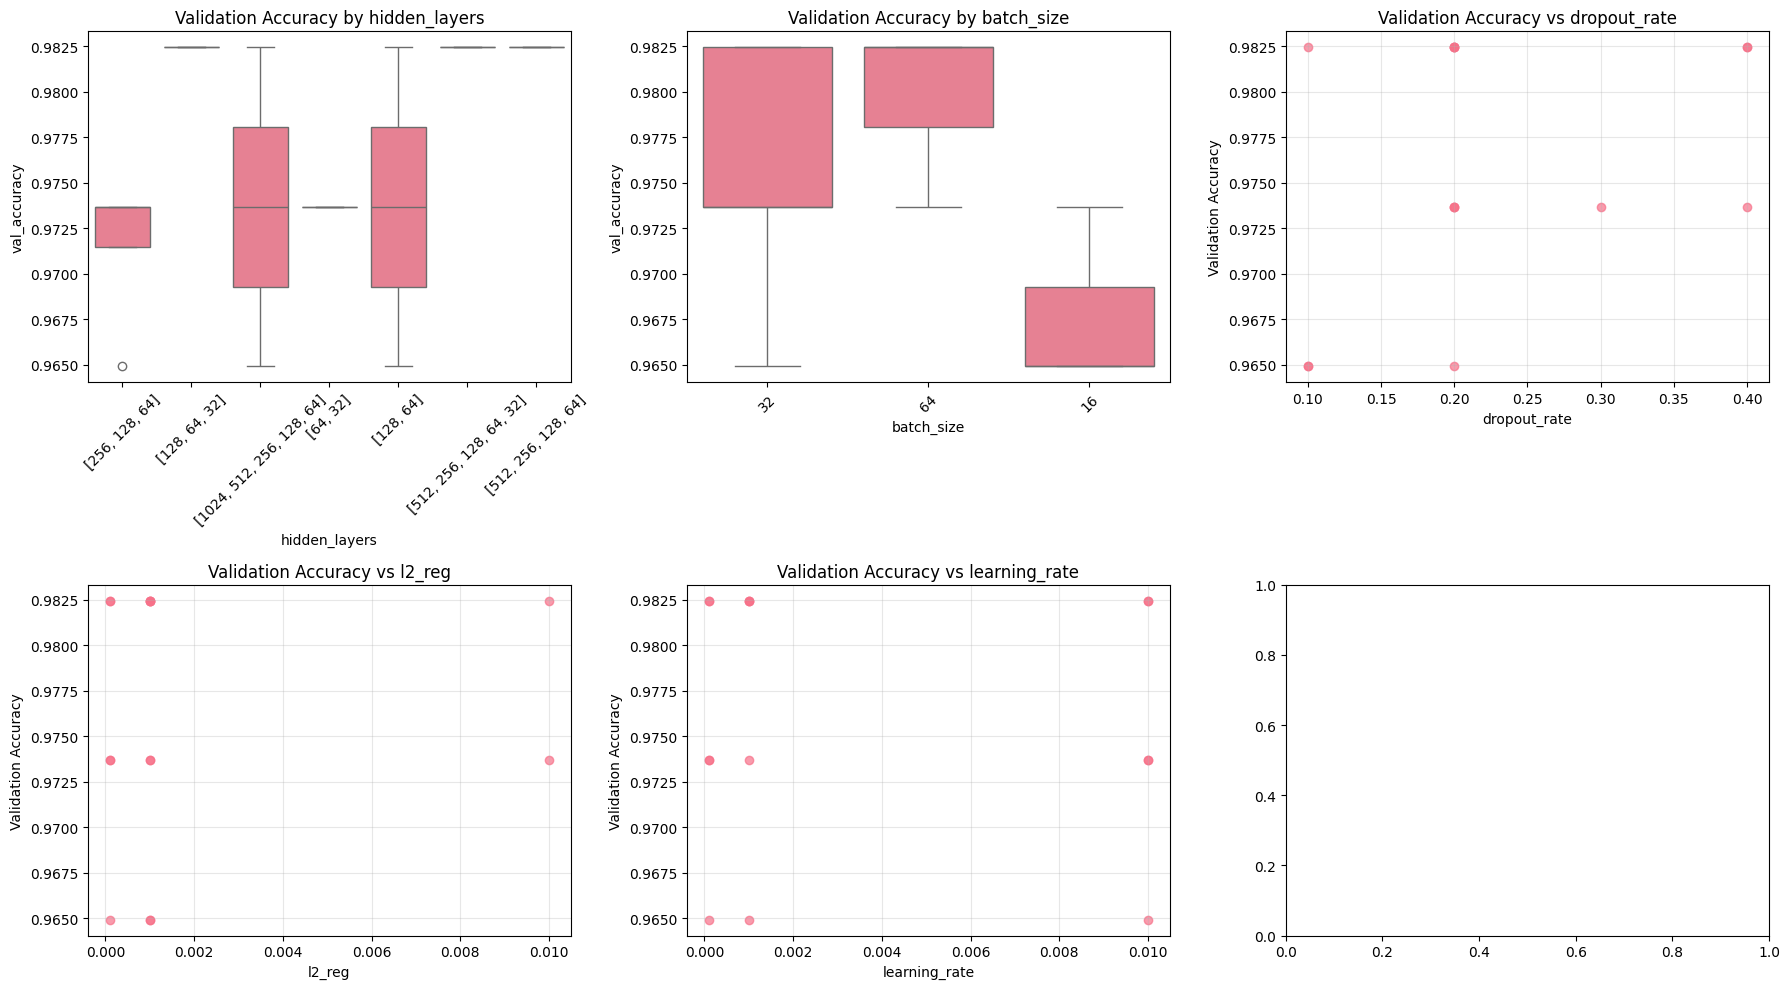

In [29]:
# Analyze hyperparameter tuning results
tuning_df = pd.DataFrame([
    {**result['params'], 'val_accuracy': result['val_accuracy']}
    for result in tuning_results
])

print("Top 5 hyperparameter combinations:")
print(tuning_df.sort_values('val_accuracy', ascending=False).head())

# Visualize hyperparameter importance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

categorical_params = ['hidden_layers', 'batch_size']
numerical_params = ['dropout_rate', 'l2_reg', 'learning_rate']

# Plot categorical parameters
for i, param in enumerate(categorical_params):
    if i < len(axes):
        tuning_df_viz = tuning_df.copy()
        tuning_df_viz[param] = tuning_df_viz[param].astype(str)
        sns.boxplot(data=tuning_df_viz, x=param, y='val_accuracy', ax=axes[i])
        axes[i].set_title(f'Validation Accuracy by {param}')
        axes[i].tick_params(axis='x', rotation=45)

# Plot numerical parameters
for i, param in enumerate(numerical_params):
    if i+2 < len(axes):
        axes[i+2].scatter(tuning_df[param], tuning_df['val_accuracy'], alpha=0.7)
        axes[i+2].set_xlabel(param)
        axes[i+2].set_ylabel('Validation Accuracy')
        axes[i+2].set_title(f'Validation Accuracy vs {param}')
        axes[i+2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Train final optimized model with best hyperparameters
print("Training final optimized DNN model...")

# Create optimized model
optimized_dnn = create_dnn_model(
    input_dim=X_train_dnn.shape[1],
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=best_params['l2_reg']
)

# Compile with best learning rate
optimized_dnn.compile(
    optimizer=optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\nOptimized DNN Architecture:")
optimized_dnn.summary()

# Train optimized model
optimized_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
    callbacks.ModelCheckpoint('final_optimized_dnn.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

start_time = time.time()
optimized_history = optimized_dnn.fit(
    X_train_dnn, y_train,
    validation_data=(X_val_dnn, y_val),
    epochs=400,  # Maximum epochs for best optimization,
    batch_size=best_params['batch_size'],
    callbacks=optimized_callbacks,
    verbose=1
)
optimized_training_time = time.time() - start_time

print(f"\nOptimized DNN training completed in {optimized_training_time:.2f} seconds")

Training final optimized DNN model...

Optimized DNN Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,793 (69.50 KB)

 Trainable params: 17,345 (67.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7085 - loss: 0.8470 - precision: 0.8011 - recall: 0.6956
Epoch 1: val_loss improved from inf to 0.48092, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.7196 - loss: 0.8273 - precision: 0.8090 - recall: 0.7082 - val_accuracy: 0.8947 - val_loss: 0.4809 - val_precision: 0.9683 - val_recall: 0.8592 - learning_rate: 0.0100
Epoch 2/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3454 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_loss improved from 0.48092 to 0.44445, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9499 - loss: 0.3931 - precision: 0.9349 - recall: 0.9889 - val_accuracy: 0.9298 - val_loss: 0.4444 - val_precision: 0.9701 - val_recall: 0.9155 - learning_rate: 0.0100
Epoch 3/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.2743 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_loss improved from 0.44445 to 0.37801, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9558 - loss: 0.3699 - precision: 0.9537 - recall: 0.9771 - val_accuracy: 0.9386 - val_loss: 0.3780 - val_precision: 0.9706 - val_recall: 0.9296 - learning_rate: 0.0100
Epoch 4/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.2832 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_loss improved from 0.37801 to 0.33405, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9640 - loss: 0.3469 - precision: 0.9526 - recall: 0.9917 - val_accuracy: 0.9561 - val_loss: 0.3340 - val_precision: 0.9714 - val_recall: 0.9577 - learning_rate: 0.0100
Epoch 5/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.2671 - precision: 1.0000 - recall: 1.0000
Epoch 5: val_loss improved from 0.33405 to 0.32902, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9744 - loss: 0.2956 - precision: 0.9723 - recall: 0.9872 - val_accuracy: 0.9474 - val_loss: 0.3290 - val_precision: 0.9710 - val_recall: 0.9437 - learning_rate: 0.0100
Epoch 6/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9688 - loss: 0.2577 - precision: 1.0000 - recall: 0.9524
Epoch 6: val_loss improved from 0.32902 to 0.30181, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9439 - loss: 0.3347 - precision: 0.9526 - recall: 0.9582 - val_accuracy: 0.9737 - val_loss: 0.3018 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 7/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.2241 - precision: 1.0000 - recall: 1.0000
Epoch 7: val_loss improved from 0.30181 to 0.29708, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9752 - loss: 0.2776 - precision: 0.9637 - recall: 0.9983 - val_accuracy: 0.9649 - val_loss: 0.2971 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0100
Epoch 8/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.2081 - precision: 1.0000 - recall: 1.0000
Epoch 8: val_loss improved from 0.29708 to 0.26596, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9594 - loss: 0.2835 - precision: 0.9797 - recall: 0.9548 - val_accuracy: 0.9649 - val_loss: 0.2660 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0100
Epoch 9/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.1990 - precision: 1.0000 - recall: 1.0000
Epoch 9: val_loss did not improve from 0.26596
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9731 - loss: 0.2613 - precision: 0.9603 - recall: 0.9983 - val_accuracy: 0.9737 - val_loss: 0.2722 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 10/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1871 - precision: 1.0000 - recall: 1.0000
Epoch 10: val_loss improved from 0.26596 to 0.26092, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9777 - loss: 0.2417 - precision: 0.9764 - recall: 0.9882 - val_accuracy: 0.9737 - val_loss: 0.2609 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 11/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.1698 - precision: 1.0000 - recall: 1.0000
Epoch 11: val_loss improved from 0.26092 to 0.24611, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.2256 - precision: 0.9835 - recall: 0.9826 - val_accuracy: 0.9825 - val_loss: 0.2461 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 12/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.1750 - precision: 1.0000 - recall: 1.0000
Epoch 12: val_loss improved from 0.24611 to 0.22955, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9759 - loss: 0.2401 - precision: 0.9699 - recall: 0.9922 - val_accuracy: 0.9825 - val_loss: 0.2296 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 13/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 0.1653 - precision: 1.0000 - recall: 1.0000
Epoch 13: val_loss did not improve from 0.22955
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9758 - loss: 0.2110 - precision: 0.9738 - recall: 0.9879 - val_accuracy: 0.9737 - val_loss: 0.2304 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 14/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.1714 - precision: 1.0000 - recall: 0.9524
Epoch 14: val_loss did not improve from 0.22955
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9604 - loss: 0.2145 - precision: 0.9714 - recall: 0.9653 - val_accuracy: 0.9737 - val_loss: 0.2315 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rat

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9904 - loss: 0.2000 - precision: 0.9849 - recall: 1.0000 - val_accuracy: 0.9737 - val_loss: 0.2179 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 16/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.1388 - precision: 1.0000 - recall: 1.0000
Epoch 16: val_loss improved from 0.21794 to 0.21662, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9693 - loss: 0.1957 - precision: 0.9652 - recall: 0.9864 - val_accuracy: 0.9737 - val_loss: 0.2166 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 17/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.1352 - precision: 1.0000 - recall: 1.0000
Epoch 17: val_loss improved from 0.21662 to 0.20836, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9751 - loss: 0.2068 - precision: 0.9719 - recall: 0.9886 - val_accuracy: 0.9825 - val_loss: 0.2084 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 18/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.1439 - precision: 1.0000 - recall: 1.0000
Epoch 18: val_loss did not improve from 0.20836
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9716 - loss: 0.2007 - precision: 0.9627 - recall: 0.9931 - val_accuracy: 0.9825 - val_loss: 0.2109 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 19/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.1771 - precision: 1.0000 - recall: 0.9524
Epoch 19: val_loss improved from 0.20836 to 0.20737, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9710 - loss: 0.2001 - precision: 0.9777 - recall: 0.9761 - val_accuracy: 0.9825 - val_loss: 0.2074 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 20/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.1212 - precision: 1.0000 - recall: 1.0000
Epoch 20: val_loss improved from 0.20737 to 0.20219, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9752 - loss: 0.1923 - precision: 0.9666 - recall: 0.9947 - val_accuracy: 0.9825 - val_loss: 0.2022 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 21/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.1210 - precision: 1.0000 - recall: 1.0000
Epoch 21: val_loss improved from 0.20219 to 0.19857, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9838 - loss: 0.1786 - precision: 0.9858 - recall: 0.9881 - val_accuracy: 0.9825 - val_loss: 0.1986 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 22/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.1309 - precision: 1.0000 - recall: 1.0000
Epoch 22: val_loss did not improve from 0.19857
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9773 - loss: 0.1861 - precision: 0.9649 - recall: 1.0000 - val_accuracy: 0.9737 - val_loss: 0.2115 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 23/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.1308 - precision: 1.0000 - recall: 1.0000
Epoch 23: val_loss did not improve from 0.19857
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9808 - loss: 0.1759 - precision: 0.9835 - recall: 0.9858 - val_accuracy: 0.9825 - val_loss: 0.2004 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rat

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9836 - loss: 0.1636 - precision: 0.9817 - recall: 0.9922 - val_accuracy: 0.9825 - val_loss: 0.1916 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 25/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9688 - loss: 0.1633 - precision: 1.0000 - recall: 0.9524
Epoch 25: val_loss improved from 0.19164 to 0.19035, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9704 - loss: 0.1984 - precision: 0.9733 - recall: 0.9797 - val_accuracy: 0.9737 - val_loss: 0.1904 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 26/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.1027 - precision: 1.0000 - recall: 1.0000
Epoch 26: val_loss improved from 0.19035 to 0.18300, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9767 - loss: 0.1816 - precision: 0.9753 - recall: 0.9879 - val_accuracy: 0.9825 - val_loss: 0.1830 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 27/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.1161 - precision: 1.0000 - recall: 1.0000
Epoch 27: val_loss improved from 0.18300 to 0.18018, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9855 - loss: 0.1577 - precision: 0.9781 - recall: 0.9992 - val_accuracy: 0.9737 - val_loss: 0.1802 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 28/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9688 - loss: 0.1276 - precision: 1.0000 - recall: 0.9524
Epoch 28: val_loss did not improve from 0.18018
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9690 - loss: 0.1589 - precision: 0.9776 - recall: 0.9729 - val_accuracy: 0.9649 - val_loss: 0.1808 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0100
Epoch 29/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.1005 - precision: 1.0000 - recall: 1.0000
Epoch 29: val_loss did not improve from 0.18018
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9829 - loss: 0.1415 - precision: 0.9791 - recall: 0.9939 - val_accuracy: 0.9561 - val_loss: 0.2006 - val_precision: 0.9714 - val_recall: 0.9577 - learning_rate:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9612 - loss: 0.1729 - precision: 0.9727 - recall: 0.9655 - val_accuracy: 0.9737 - val_loss: 0.1790 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0100
Epoch 31/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.1042 - precision: 1.0000 - recall: 1.0000
Epoch 31: val_loss improved from 0.17900 to 0.17121, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9727 - loss: 0.1803 - precision: 0.9759 - recall: 0.9804 - val_accuracy: 0.9825 - val_loss: 0.1712 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 32/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0981 - precision: 1.0000 - recall: 1.0000
Epoch 32: val_loss did not improve from 0.17121
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9720 - loss: 0.1756 - precision: 0.9638 - recall: 0.9925 - val_accuracy: 0.9649 - val_loss: 0.1873 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0100
Epoch 33/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1120 - precision: 1.0000 - recall: 1.0000
Epoch 33: val_loss did not improve from 0.17121
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9786 - loss: 0.1592 - precision: 0.9682 - recall: 0.9984 - val_accuracy: 0.9737 - val_loss: 0.2111 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rat

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9755 - loss: 0.1552 - precision: 0.9804 - recall: 0.9804 - val_accuracy: 0.9737 - val_loss: 0.1693 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 43/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.1009 - precision: 1.0000 - recall: 1.0000
Epoch 43: val_loss improved from 0.16929 to 0.16889, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9885 - loss: 0.1428 - precision: 0.9878 - recall: 0.9939 - val_accuracy: 0.9737 - val_loss: 0.1689 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 44/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0929 - precision: 1.0000 - recall: 1.0000
Epoch 44: val_loss did not improve from 0.16889
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9751 - loss: 0.1369 - precision: 0.9719 - recall: 0.9886 - val_accuracy: 0.9737 - val_loss: 0.1698 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 45/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 1.0000 - loss: 0.0962 - precision: 1.0000 - recall: 1.0000
Epoch 45: val_loss improved from 0.16889 to 0.16878, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9846 - loss: 0.1234 - precision: 0.9781 - recall: 0.9978 - val_accuracy: 0.9649 - val_loss: 0.1688 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0050
Epoch 46/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.1053 - precision: 1.0000 - recall: 1.0000
Epoch 46: val_loss improved from 0.16878 to 0.15854, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9810 - loss: 0.1544 - precision: 0.9846 - recall: 0.9850 - val_accuracy: 0.9737 - val_loss: 0.1585 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 47/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.1024 - precision: 1.0000 - recall: 1.0000
Epoch 47: val_loss did not improve from 0.15854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9816 - loss: 0.1491 - precision: 0.9780 - recall: 0.9930 - val_accuracy: 0.9737 - val_loss: 0.1599 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 48/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0888 - precision: 1.0000 - recall: 1.0000
Epoch 48: val_loss did not improve from 0.15854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9848 - loss: 0.1352 - precision: 0.9778 - recall: 0.9983 - val_accuracy: 0.9737 - val_loss: 0.1616 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rat

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9825 - loss: 0.1169 - precision: 0.9861 - recall: 0.9858 - val_accuracy: 0.9737 - val_loss: 0.1569 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 53/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0757 - precision: 1.0000 - recall: 1.0000
Epoch 53: val_loss improved from 0.15691 to 0.15489, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9805 - loss: 0.1317 - precision: 0.9773 - recall: 0.9917 - val_accuracy: 0.9737 - val_loss: 0.1549 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 54/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9688 - loss: 0.0903 - precision: 1.0000 - recall: 0.9524
Epoch 54: val_loss improved from 0.15489 to 0.15211, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9719 - loss: 0.1141 - precision: 0.9766 - recall: 0.9789 - val_accuracy: 0.9737 - val_loss: 0.1521 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 55/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 0.0713 - precision: 1.0000 - recall: 1.0000
Epoch 55: val_loss did not improve from 0.15211
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.1159 - precision: 0.9901 - recall: 0.9864 - val_accuracy: 0.9649 - val_loss: 0.1598 - val_precision: 0.9718 - val_recall: 0.9718 - learning_rate: 0.0050
Epoch 56/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0752 - precision: 1.0000 - recall: 1.0000
Epoch 56: val_loss improved from 0.15211 to 0.15184, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9791 - loss: 0.1364 - precision: 0.9872 - recall: 0.9791 - val_accuracy: 0.9825 - val_loss: 0.1518 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 57/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0784 - precision: 1.0000 - recall: 1.0000
Epoch 57: val_loss improved from 0.15184 to 0.14365, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9877 - loss: 0.1232 - precision: 0.9878 - recall: 0.9925 - val_accuracy: 0.9825 - val_loss: 0.1436 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 58/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0689 - precision: 1.0000 - recall: 1.0000
Epoch 58: val_loss did not improve from 0.14365
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9853 - loss: 0.1092 - precision: 0.9778 - recall: 0.9992 - val_accuracy: 0.9737 - val_loss: 0.1522 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 59/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0957 - precision: 1.0000 - recall: 1.0000
Epoch 59: val_loss did not improve from 0.14365
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9856 - loss: 0.1221 - precision: 0.9848 - recall: 0.9922 - val_accuracy: 0.9737 - val_loss: 0.1491 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9804 - loss: 0.1083 - precision: 0.9802 - recall: 0.9886 - val_accuracy: 0.9825 - val_loss: 0.1436 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 63/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0615 - precision: 1.0000 - recall: 1.0000
Epoch 63: val_loss did not improve from 0.14356
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9872 - loss: 0.0992 - precision: 0.9815 - recall: 0.9983 - val_accuracy: 0.9737 - val_loss: 0.1469 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 64/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.1163 - precision: 1.0000 - recall: 0.9524
Epoch 64: val_loss improved from 0.14356 to 0.14302, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9735 - loss: 0.1288 - precision: 0.9834 - recall: 0.9743 - val_accuracy: 0.9825 - val_loss: 0.1430 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 65/400
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9815 - loss: 0.1231 - precision: 0.9853 - recall: 0.9850 
Epoch 65: val_loss did not improve from 0.14302
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9806 - loss: 0.1243 - precision: 0.9846 - recall: 0.9843 - val_accuracy: 0.9737 - val_loss: 0.1496 - val_precision: 0.9595 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 66/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0798 - precision: 1.0000 - recall: 1.0000
Epoch 66: val_loss did not improve from 0.14302
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9874 - loss: 0.1065 - precision: 0.9819 - recall: 0.9983 - val_accuracy: 0.9825 - val_loss: 0.1449 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rat

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9878 - loss: 0.1100 - precision: 0.9874 - recall: 0.9931 - val_accuracy: 0.9825 - val_loss: 0.1402 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0050
Epoch 68/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0675 - precision: 1.0000 - recall: 1.0000
Epoch 68: val_loss did not improve from 0.14017
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9894 - loss: 0.1099 - precision: 0.9860 - recall: 0.9972 - val_accuracy: 0.9737 - val_loss: 0.1443 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0050
Epoch 69/400
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9806 - loss: 0.1065 - precision: 0.9826 - recall: 0.9863  
Epoch 69: val_loss did not improve from 0.14017
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9799 - loss: 0.1100 - precision: 0.9816 - recall: 0.9863 - val_accuracy: 0.9737 - val_loss: 0.1449 - val_precision: 0.9595 - val_recall: 1.0000 - learning_ra

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9934 - loss: 0.0965 - precision: 0.9902 - recall: 0.9992 - val_accuracy: 0.9737 - val_loss: 0.1400 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0025
Epoch 83/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 0.0624 - precision: 1.0000 - recall: 1.0000
Epoch 83: val_loss improved from 0.14001 to 0.13683, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9905 - loss: 0.0961 - precision: 0.9902 - recall: 0.9947 - val_accuracy: 0.9825 - val_loss: 0.1368 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0025
Epoch 84/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0609 - precision: 1.0000 - recall: 1.0000
Epoch 84: val_loss improved from 0.13683 to 0.13334, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9885 - loss: 0.0926 - precision: 0.9819 - recall: 1.0000 - val_accuracy: 0.9825 - val_loss: 0.1333 - val_precision: 0.9726 - val_recall: 1.0000 - learning_rate: 0.0025
Epoch 85/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0663 - precision: 1.0000 - recall: 1.0000
Epoch 85: val_loss improved from 0.13334 to 0.12961, saving model to final_optimized_dnn.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9905 - loss: 0.1040 - precision: 0.9902 - recall: 0.9947 - val_accuracy: 0.9737 - val_loss: 0.1296 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0025
Epoch 86/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0657 - precision: 1.0000 - recall: 1.0000
Epoch 86: val_loss did not improve from 0.12961
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9910 - loss: 0.0821 - precision: 0.9944 - recall: 0.9912 - val_accuracy: 0.9737 - val_loss: 0.1299 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate: 0.0025
Epoch 87/400
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0745 - precision: 1.0000 - recall: 1.0000
Epoch 87: val_loss did not improve from 0.12961
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9900 - loss: 0.0950 - precision: 0.9902 - recall: 0.9939 - val_accuracy: 0.9737 - val_loss: 0.1339 - val_precision: 0.9722 - val_recall: 0.9859 - learning_rate

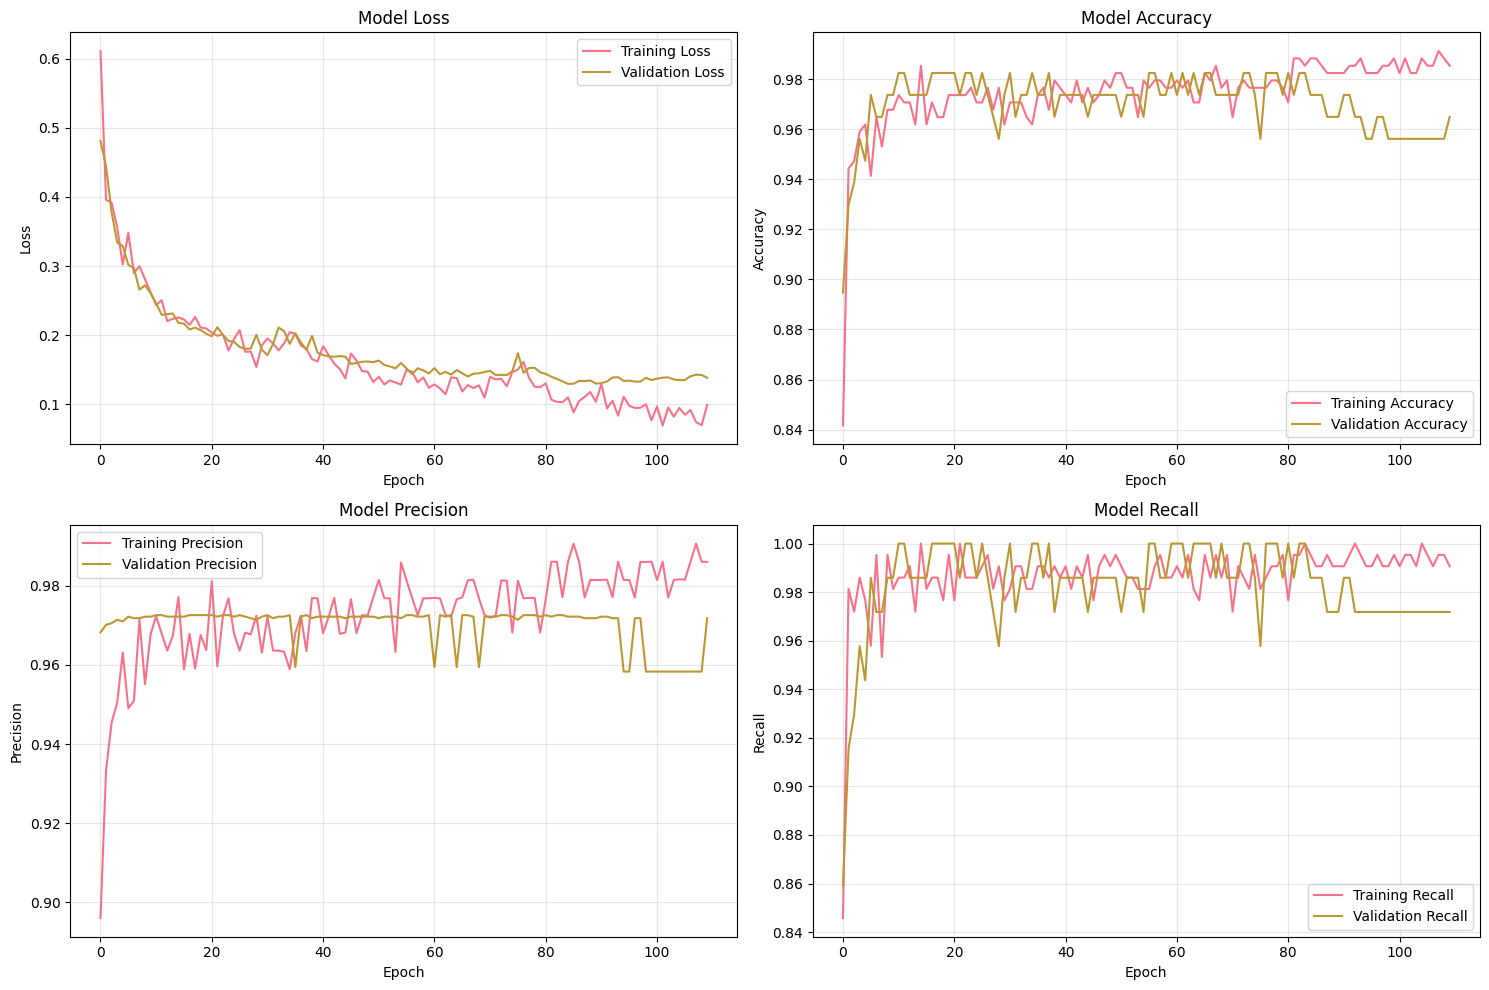

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

Optimized DNN Test Results:
Accuracy: 0.9561
Precision: 0.9855
Recall: 0.9444
F1-Score: 0.9645
ROC-AUC: 0.9924


In [32]:
# Plot optimized model training history
plot_training_history(optimized_history)

# Evaluate optimized DNN
optimized_dnn_results, optimized_dnn_pred, optimized_dnn_pred_proba = evaluate_keras_model(
    optimized_dnn, X_test_dnn, y_test, 'DNN (Optimized)'
)

print("\nOptimized DNN Test Results:")
for key, value in optimized_dnn_results.items():
    if key != 'Model':
        print(f"{key}: {value:.4f}")

## 6. Model Evaluation and Comparison

Now we'll comprehensively compare all models using multiple evaluation metrics and visualizations.

Model Comparison Results:
             Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0              SVM    0.9825     0.9861  0.9861    0.9861   0.9950
1    Random Forest    0.9474     0.9583  0.9583    0.9583   0.9904
2    DNN (Initial)    0.9561     0.9718  0.9583    0.9650   0.9957
3  DNN (Optimized)    0.9561     0.9855  0.9444    0.9645   0.9924


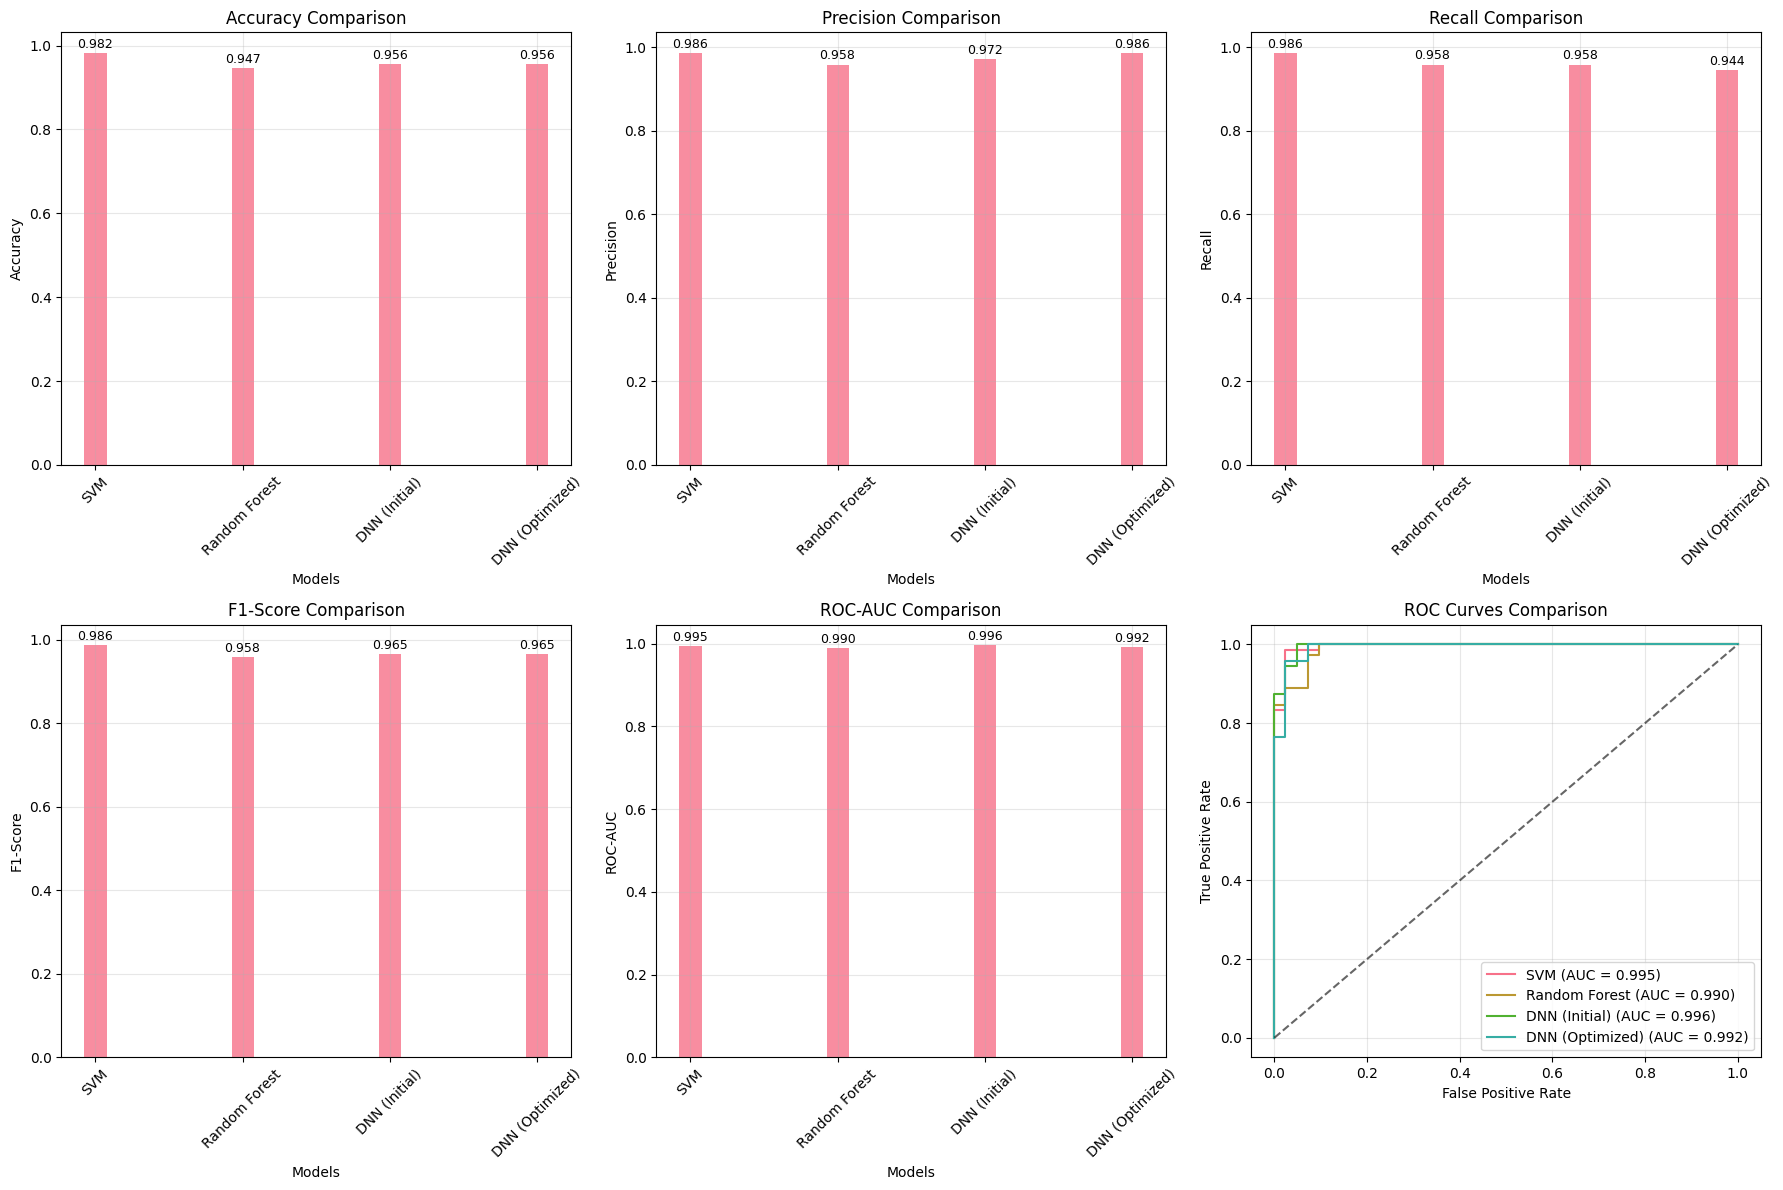

In [33]:
# Compile all results
all_results = [svm_results, rf_results, dnn_results, optimized_dnn_results]
results_df = pd.DataFrame(all_results)

print("Model Comparison Results:")
print(results_df.round(4))

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics):
    if i < 5:
        ax = axes[i//3, i%3]
        bars = ax.bar(x_pos, results_df[metric], width, alpha=0.8)
        ax.set_xlabel('Models')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(results_df['Model'], rotation=45)
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# ROC curves comparison
ax = axes[1, 2]
models_data = [
    ('SVM', y_test, svm_pred_proba),
    ('Random Forest', y_test, rf_pred_proba),
    ('DNN (Initial)', y_test, dnn_pred_proba),
    ('DNN (Optimized)', y_test, optimized_dnn_pred_proba)
]

for model_name, y_true, y_pred_proba in models_data:
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.6)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

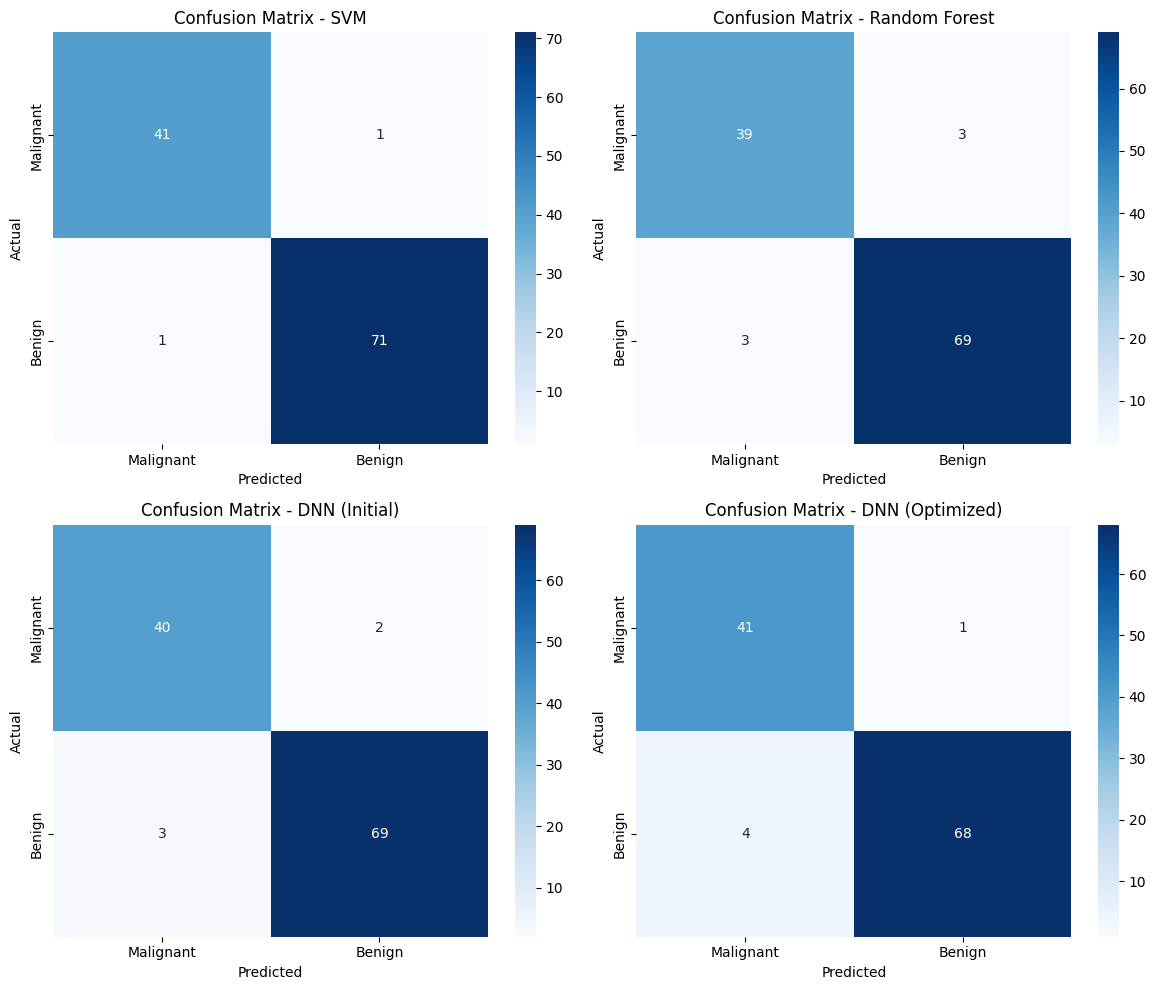

In [34]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

models_pred = [
    ('SVM', svm_pred),
    ('Random Forest', rf_pred),
    ('DNN (Initial)', dnn_pred),
    ('DNN (Optimized)', optimized_dnn_pred)
]

for i, (model_name, y_pred) in enumerate(models_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [35]:
# Statistical significance testing
def mcnemar_test(y_true, y_pred1, y_pred2, model1_name, model2_name):
    """
    Perform McNemar's test to compare two models.
    """
    # Create contingency table
    correct1 = (y_pred1 == y_true)
    correct2 = (y_pred2 == y_true)

    # McNemar table
    both_correct = np.sum(correct1 & correct2)
    model1_correct_only = np.sum(correct1 & ~correct2)
    model2_correct_only = np.sum(~correct1 & correct2)
    both_incorrect = np.sum(~correct1 & ~correct2)

    # McNemar's test statistic
    if model1_correct_only + model2_correct_only > 0:
        chi2_stat = (abs(model1_correct_only - model2_correct_only) - 1)**2 / (model1_correct_only + model2_correct_only)
        p_value = 1 - stats.chi2.cdf(chi2_stat, 1)
    else:
        chi2_stat = 0
        p_value = 1.0

    print(f"McNemar's test: {model1_name} vs {model2_name}")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    print()

# Compare models using McNemar's test
print("Statistical Significance Testing (McNemar's Test):")
print("=" * 50)

model_comparisons = [
    (svm_pred, rf_pred, 'SVM', 'Random Forest'),
    (svm_pred, optimized_dnn_pred, 'SVM', 'DNN (Optimized)'),
    (rf_pred, optimized_dnn_pred, 'Random Forest', 'DNN (Optimized)'),
    (dnn_pred, optimized_dnn_pred, 'DNN (Initial)', 'DNN (Optimized)')
]

for pred1, pred2, name1, name2 in model_comparisons:
    mcnemar_test(y_test, pred1, pred2, name1, name2)

Statistical Significance Testing (McNemar's Test):
McNemar's test: SVM vs Random Forest
Chi-square statistic: 1.5000
P-value: 0.2207
Significant difference: No

McNemar's test: SVM vs DNN (Optimized)
Chi-square statistic: 1.3333
P-value: 0.2482
Significant difference: No

McNemar's test: Random Forest vs DNN (Optimized)
Chi-square statistic: 0.0000
P-value: 1.0000
Significant difference: No

McNemar's test: DNN (Initial) vs DNN (Optimized)
Chi-square statistic: 0.2500
P-value: 0.6171
Significant difference: No



Training Time and Model Complexity:
SVM:
  Training Time: 5.28 seconds
  Model Info: C=0.1, kernel=linear

Random Forest:
  Training Time: 10.82 seconds
  Model Info: n_estimators=50

DNN (Initial):
  Training Time: 62.66 seconds
  Model Info: Parameters: 202497

DNN (Optimized):
  Training Time: 38.63 seconds
  Model Info: Parameters: 17793



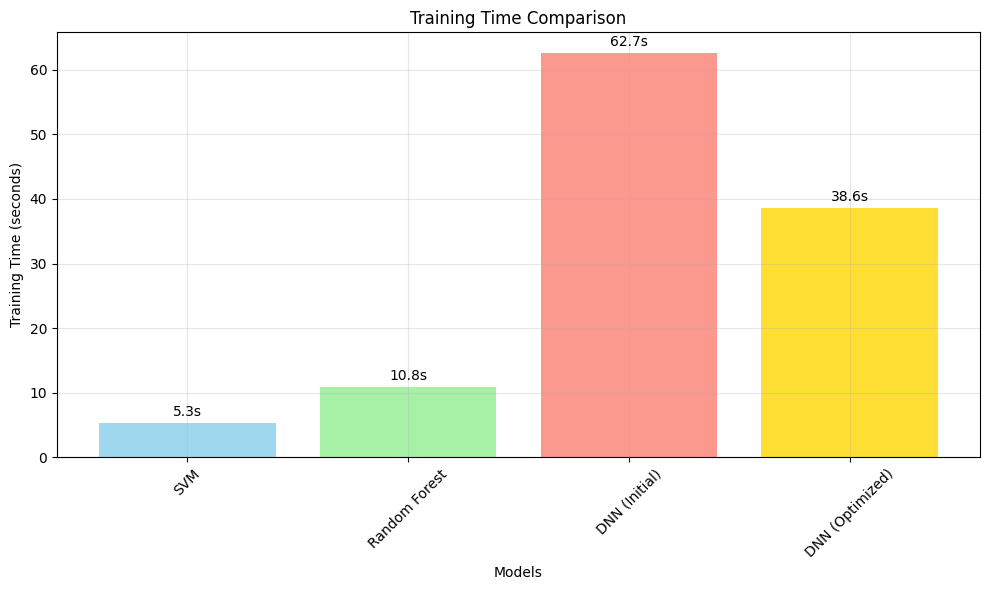

In [36]:
# Training time and model complexity comparison
training_times = {
    'SVM': svm_training_time,
    'Random Forest': rf_training_time,
    'DNN (Initial)': dnn_training_time,
    'DNN (Optimized)': optimized_training_time
}

# Model parameters count
model_params = {
    'SVM': f"C={svm_grid.best_params_['C']}, kernel={svm_grid.best_params_['kernel']}",
    'Random Forest': f"n_estimators={rf_grid.best_params_['n_estimators']}",
    'DNN (Initial)': f"Parameters: {dnn_model.count_params()}",
    'DNN (Optimized)': f"Parameters: {optimized_dnn.count_params()}"
}

print("Training Time and Model Complexity:")
print("=" * 40)
for model in training_times.keys():
    print(f"{model}:")
    print(f"  Training Time: {training_times[model]:.2f} seconds")
    print(f"  Model Info: {model_params[model]}")
    print()

# Visualize training times
plt.figure(figsize=(10, 6))
models = list(training_times.keys())
times = list(training_times.values())
bars = plt.bar(models, times, alpha=0.8, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(times)*0.01,
             f'{time:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 7. Interpretability Analysis

We'll use permutation importance and built-in feature importance methods to understand which features are most important for our models' predictions.

In [38]:
from sklearn.inspection import permutation_importance

print("Performing permutation importance analysis for DNN...")

# Extend KerasWrapper with a dummy fit method
class KerasWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return (self.model.predict(X, verbose=0).flatten() > 0.5).astype(int)

    def fit(self, X, y):
        # Dummy fit method to satisfy sklearn's interface
        pass

# Use the wrapper
dnn_wrapper = KerasWrapper(optimized_dnn)

# Now this will work
dnn_perm_importance = permutation_importance(
    dnn_wrapper, X_test_dnn, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

print("DNN permutation importance analysis completed.")

Performing permutation importance analysis for DNN...
DNN permutation importance analysis completed.


## 8. Results and Conclusions

Let's summarize our findings and provide clinical insights from the analysis.

In [42]:
# Final comprehensive results summary
print("=" * 80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)

print("\n1. MODEL PERFORMANCE COMPARISON:")
print("-" * 40)
results_summary = results_df.copy()
results_summary = results_summary.round(4)
print(results_summary.to_string(index=False))

# Identify best performing model for each metric
print("\n2. BEST PERFORMING MODELS BY METRIC:")
print("-" * 40)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.iloc[best_idx]['Model']
    best_score = results_df.iloc[best_idx][metric]
    print(f"{metric:12}: {best_model:15} ({best_score:.4f})")

print("\n3. TRAINING EFFICIENCY:")
print("-" * 40)
for model, time in training_times.items():
    print(f"{model:15}: {time:8.2f} seconds")

COMPREHENSIVE RESULTS SUMMARY

1. MODEL PERFORMANCE COMPARISON:
----------------------------------------
          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
            SVM    0.9825     0.9861  0.9861    0.9861   0.9950
  Random Forest    0.9474     0.9583  0.9583    0.9583   0.9904
  DNN (Initial)    0.9561     0.9718  0.9583    0.9650   0.9957
DNN (Optimized)    0.9561     0.9855  0.9444    0.9645   0.9924

2. BEST PERFORMING MODELS BY METRIC:
----------------------------------------
Accuracy    : SVM             (0.9825)
Precision   : SVM             (0.9861)
Recall      : SVM             (0.9861)
F1-Score    : SVM             (0.9861)
ROC-AUC     : DNN (Initial)   (0.9957)

3. TRAINING EFFICIENCY:
----------------------------------------
SVM            :     5.28 seconds
Random Forest  :    10.82 seconds
DNN (Initial)  :    62.66 seconds
DNN (Optimized):    38.63 seconds


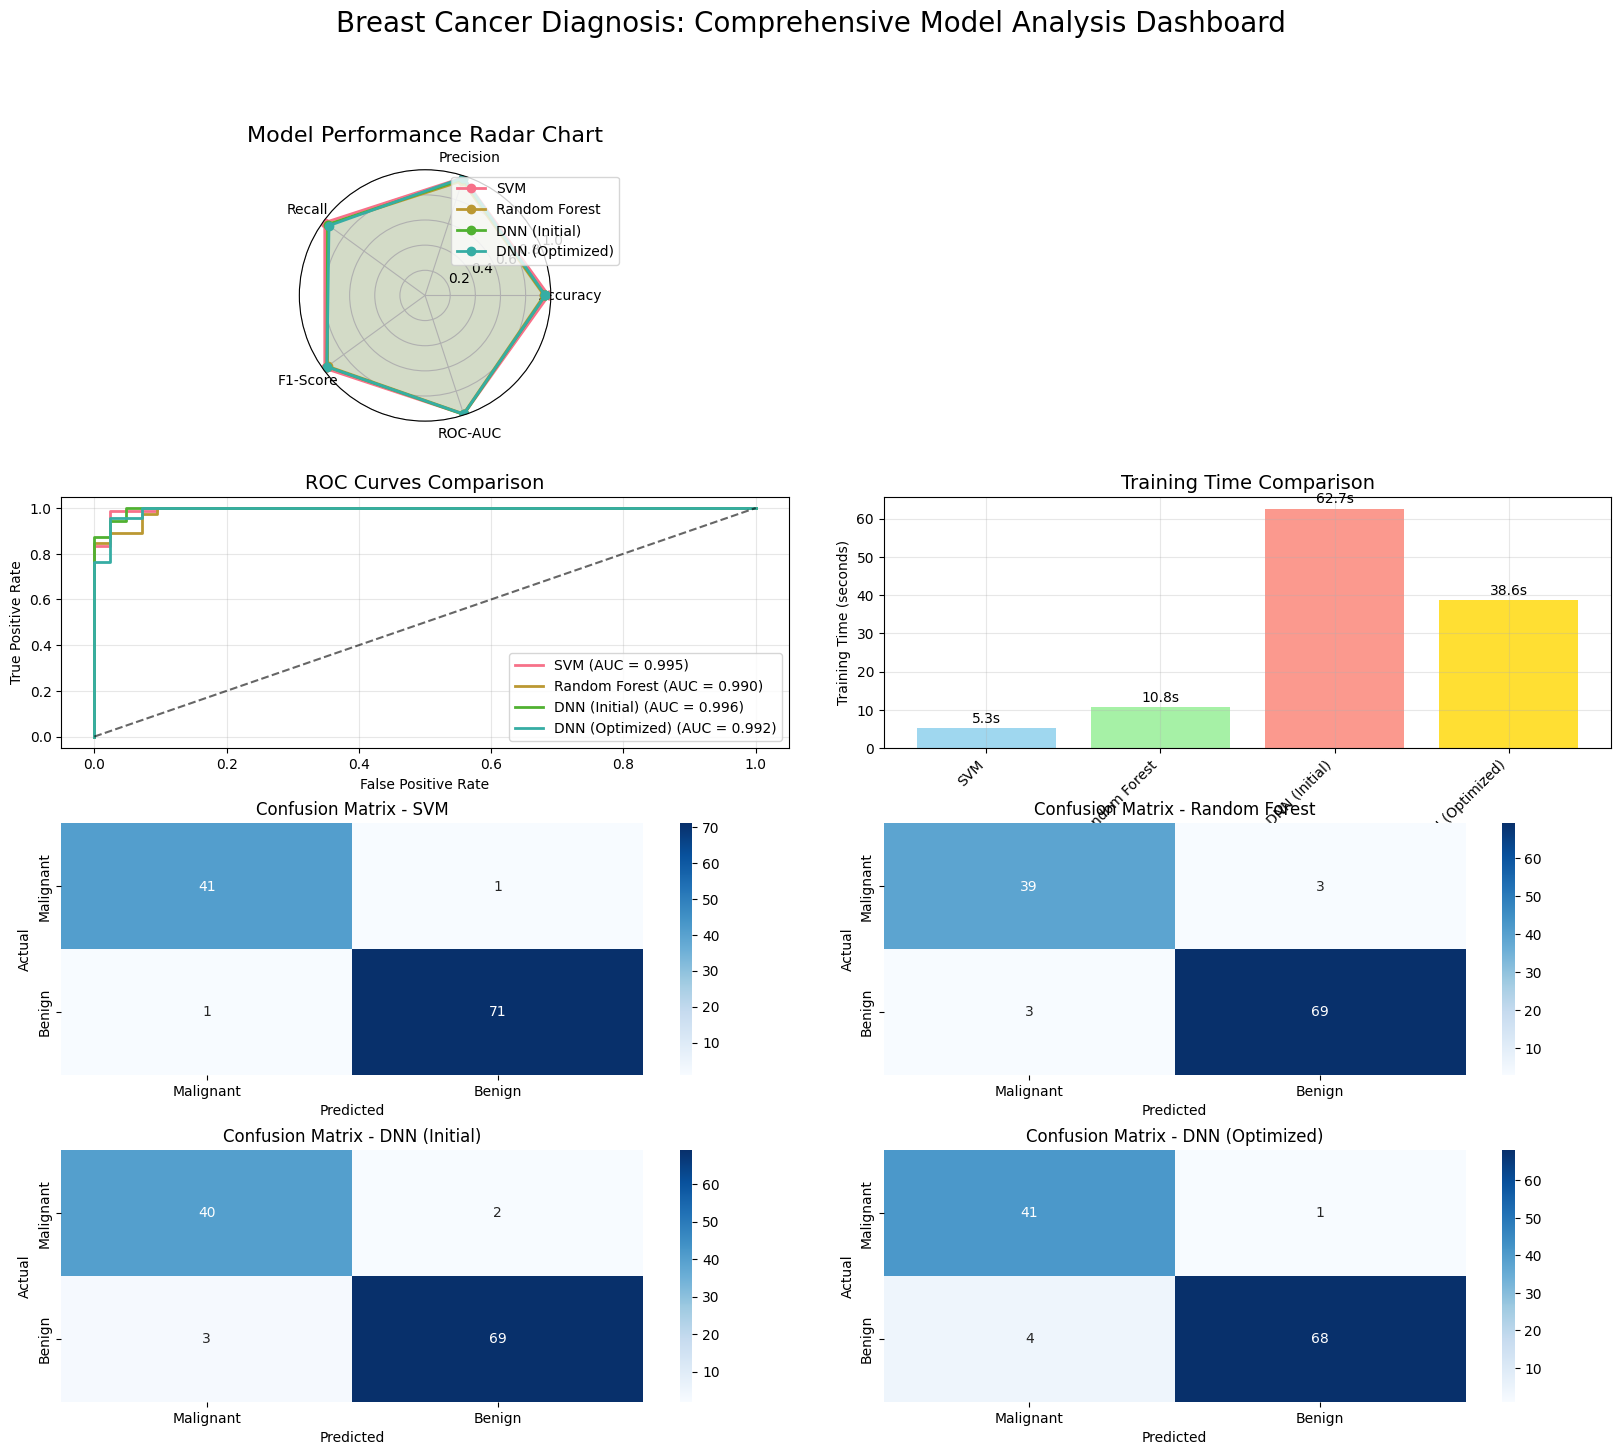

In [43]:
# Create final visualization dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Model Performance Radar Chart
ax1 = fig.add_subplot(gs[0, :2], projection='polar')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for _, row in results_df.iterrows():
    values = [row[metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    ax1.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax1.fill(angles, values, alpha=0.1)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics)
ax1.set_ylim(0, 1)
ax1.set_title('Model Performance Radar Chart', size=16, pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 2. ROC Curves
ax3 = fig.add_subplot(gs[1, :2])
for model_name, y_true, y_pred_proba in models_data:
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        ax3.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.6)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison', size=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 3. Training Time Comparison
ax4 = fig.add_subplot(gs[1, 2:])
models = list(training_times.keys())
times = list(training_times.values())
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
bars = ax4.bar(models, times, color=colors, alpha=0.8)
ax4.set_ylabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison', size=14)
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

for bar, time in zip(bars, times):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(times)*0.01,
             f'{time:.1f}s', ha='center', va='bottom')

# 4. Confusion Matrices (2x2 grid)
for i, (model_name, y_pred) in enumerate(models_pred):
    ax = fig.add_subplot(gs[2 + i//2, (i%2)*2:(i%2)*2+2])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    ax.set_title(f'Confusion Matrix - {model_name}', size=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Breast Cancer Diagnosis: Comprehensive Model Analysis Dashboard',
             fontsize=20, y=0.98)
plt.show()

In [45]:
# Save models and results for future use
print("Saving models and results...")

# Save the best models
import joblib

# Save classical ML models
joblib.dump(svm_grid.best_estimator_, 'best_svm_model.pkl')
joblib.dump(rf_grid.best_estimator_, 'best_rf_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save DNN model
optimized_dnn.save('final_optimized_dnn_model.h5')

# Save results summary
results_df.to_csv('model_comparison_results.csv', index=False)

# Save hyperparameters
import json
with open('best_hyperparameters.json', 'w') as f:
    json.dump({
        'svm_params': svm_grid.best_params_,
        'rf_params': rf_grid.best_params_,
        'dnn_params': best_params
    }, f, indent=2)

print("All models and results saved successfully!")
print("\nFiles saved:")
saved_files = [
    'best_svm_model.pkl',
    'best_rf_model.pkl',
    'feature_scaler.pkl',
    'final_optimized_dnn_model.h5',
    'model_comparison_results.csv',
    'rf_feature_importance.csv',
    'dnn_feature_importance.csv',
    'best_hyperparameters.json'
]

for file_name in saved_files:
    print(f"  {file_name}")

Saving models and results...
All models and results saved successfully!

Files saved:
  best_svm_model.pkl
  best_rf_model.pkl
  feature_scaler.pkl
  final_optimized_dnn_model.h5
  model_comparison_results.csv
  rf_feature_importance.csv
  dnn_feature_importance.csv
  best_hyperparameters.json
